## Data sources & Descriptions
### U.S. Average Price of Crude Oil


Value represents the benchmark prices which are representative of the global market. Prices are period averages in nominal U.S. dollars.


**Units:**  U.S. Dollars per Barrel, Not Seasonally Adjusted  

**Frequency:**  Monthly  

**Meta Data:**  
- **Time:** Monthly (from Jan. 2016 to October 2020)  
- **Price:** Price of oil in nominal U.S. dollars.  

**Source:** https://www.eia.gov/outlooks/steo/archives/mar20_base.xlsx  

### U.S. Crude Oil Production, Monthly  

Value represents the U.S. total production of Crude Oil in the US.  
**Units:**  Million barrels per day

**Meta Data:**  
- **Series name:** Title of Source  
- **Period:**  Monthly (from Jan. 1990 to October 2020)  
- **Frequency:**  Monthly  
- **Value:** U.S. total production of Crude Oil in the US for that Month  
- **Units:** Million barrels per day  

**Source:**  https://www.eia.gov/opendata/qb.php?sdid=STEO.COPRPUS.M

## The Plan 
- First, I am going to explore four forecasting models, these models are: the Naive/No Change Forecast (Sometimes called a Random Walk), Arima Model, and a Leading Indicator Model where I use USA's total production of crude oil as a Leading Indicator, and lastly the professional forecast done by EIA.   

- I compare and contrast the models by using two criterion, Mean Squared Error and Mean Absolute Error (I will talk about it later).  

- Next, I will combine 3 models together using 3 different combination methods. I will then compare and contrast them.

## Cut off date
The cut off date chosen will be March 1st 2020. I will refer to every date less than March 1st 2020 as precovid data, every date after March 1st 2020 will be refered as postcovid date.  
- pre-covid < March 2020, post-covid >= March 2020  

## Forecast
- I am interested in how these models perform doing **long term forecast**
-  I will **forecast out 7 months ahead** from the cut off date **March 1st 2020** (i.e. forecast **March 2020 to October 2020**).  
  
## Forecasting Variable
- The variable I will forecast on is the Average Price of Crude Oil in the USA.  


# Setting Up
## Imports & Paths

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima_model import ARIMA
import numpy as np 
from sklearn.metrics import mean_squared_error
import warnings                                  
warnings.filterwarnings('ignore')

input_path = '/home/semipro321/Dropbox/GradSchool/Econ 5880/workplace/A2/Input/'
us_crude_prices = 'U.S._Crude_Oil_First_Purchase_Price_Monthly.csv'
us_crude_production = 'U.S._Crude_Oil_Production_Monthly.csv'
us_crude_ave_price_nov = 'US_average_energy_price_nov.csv'
us_crude_ave_price_mar = 'US_average_energy_price_mar.csv'
xle_stock = 'XLE.csv'

## Reading the CSV & Exploring
Here we have `dfprices` being the dataframe containing the true data values for the actual average prices of crude oil from Jan. 2016 to Oct. 2020. `dfpricesprof` is the dataframe containing the true data values for the actual average prices of crude oil from Jan. 2016 to Feb. 2020 and then the professional predicted values from Mar. 2020 to Oct. 2020

In [2]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

dfprices = pd.read_csv(input_path + us_crude_ave_price_nov, header=None)
dfpricesprof = pd.read_csv(input_path + us_crude_ave_price_mar, header=None)
startdate =  datetime.strptime('2016-01-01', '%Y-%m-%d')
datelistnov = []
for i in range(len(dfprices)):
    datelistnov.append(startdate)
    startdate += relativedelta(months=1)
dfprices.index = datelistnov

datelistmar = []
startdate =  datetime.strptime('2016-01-01', '%Y-%m-%d')
for i in range(len(dfpricesprof)):
    datelistmar.append(startdate)
    startdate += relativedelta(months=1)
dfpricesprof.index = datelistmar

dfprices.rename(columns={0: "Price"}, inplace=True)
dfpricesprof.rename(columns={0: "Price"}, inplace=True)
date_index = '2020-10-01'
dfprices = dfprices[dfprices.index <= date_index].sort_index(ascending=False)
dfpricesprof = dfpricesprof[dfpricesprof.index <= date_index].sort_index(ascending=False)

In [3]:
dfprices.info()
dfpricesprof.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58 entries, 2020-10-01 to 2016-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   58 non-null     float64
dtypes: float64(1)
memory usage: 928.0 bytes
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58 entries, 2020-10-01 to 2016-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   58 non-null     float64
dtypes: float64(1)
memory usage: 928.0 bytes


In [4]:
dfprices.describe()


,Price
count,58.000000
mean,49.007586
std,12.002630
min,16.740000
25%,41.277500
50%,48.750000
75%,57.407500
max,67.790000


In [5]:
dfpricesprof.describe()

,Price
count,58.000000
mean,48.743966
std,12.024483
min,26.350000
25%,41.277500
50%,48.750000
75%,57.407500
max,67.790000


## Creating Our Plotting Function for Reproducibility

In [6]:
def plotregular(true, pred=None, X_label='Time', Y_label='Price per barrel', title='Monthly Prices per barrel of crude oil', trueplotlabel='Dollars per barrel', predplotlabel=None, postcovid=False, eval=False, precovid=False):
    test_index = '2020-03-01'
    if pred is not None:
        pred = pred[pred.index >= test_index]
    if precovid == True:
        true = true[true.index >= '2019-10-01']
    if postcovid == True:
        true = true[true.index >= test_index]
    plt.figure(figsize=(20, 10))
    if pred is not None:
        plt.plot(pred, label=predplotlabel, color='red')
    if eval == False:
        plt.title(title, fontsize=20)
    else:
        trueeval = true[true.index >= test_index]
        MAPE = mean_absolute_percentage_error(trueeval, pred)
        MSE = mean_squared_error(trueeval, pred)
        plt.title(f'MSE: {MSE} and MAPE:{MAPE}', fontsize=20)
        print(f'The MSE: {MSE} and MAPE:{MAPE}')
    plt.plot(true, label=trueplotlabel)
    if postcovid == False:
        plt.axvline(x=test_index, color='orange', linestyle='--', dashes=(5, 5), label="Covid-19 Cut Off Date")
    plt.legend(loc="best", fontsize=15)
    plt.xlabel(X_label, fontsize=20)
    plt.ylabel(Y_label,fontsize=20)
    plt.tight_layout()
    plt.grid(True)
    plt.show();
    


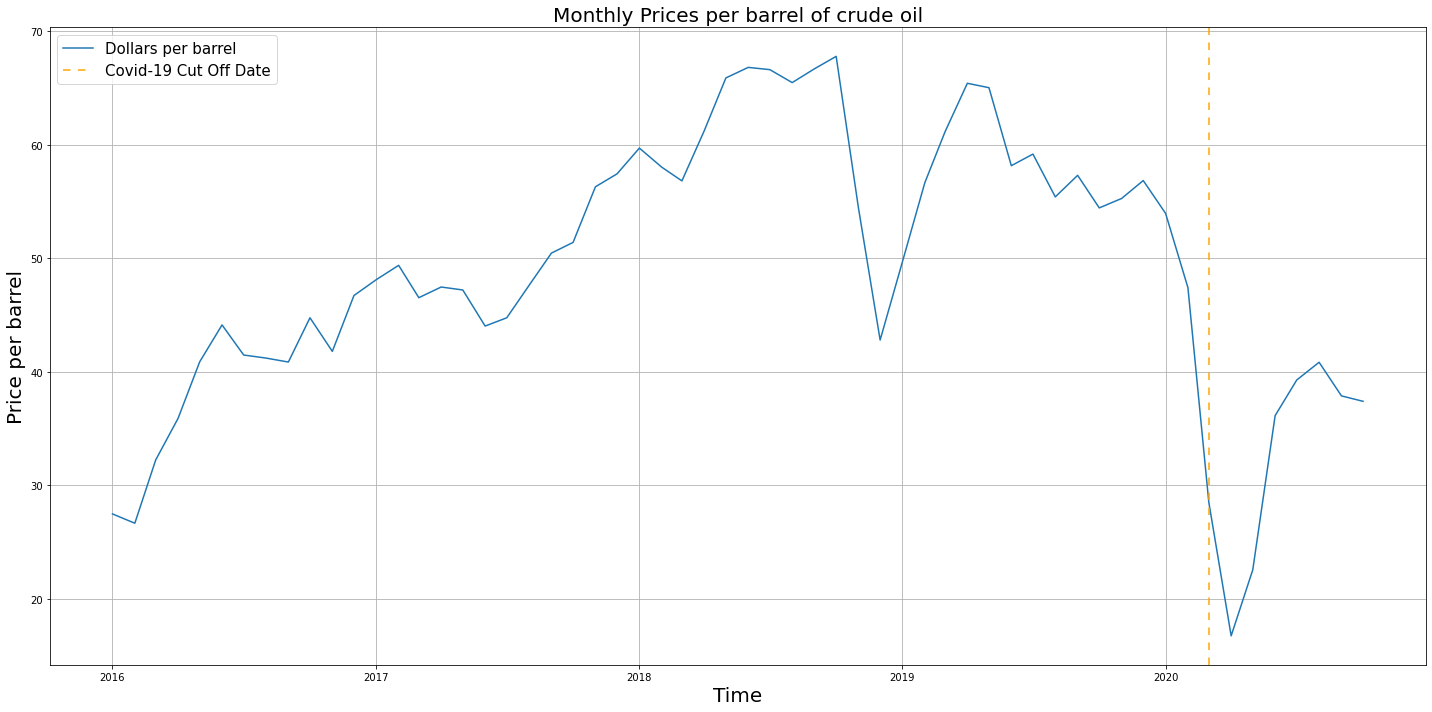

In [7]:
plotregular(dfprices)

# Creating MAPE  & MSE Evaluation Criteria
I will be using two different forecast criteria to compare our models.
1. Mean Squared Forecasting Error (MSFE)
2. Mean Absolute Percentage  Error  (MAPE)

Note that the MAPE is the criterion is the U.S. Department of Energy EIA agency’s criterion of choice.
The MSE is scale-dependent, MAPE is not. So if you are comparing accuracy across time series with different scales, we can't use MSE.  If you want an unbiased forecast, MSE is better than the MAPE

The MAPE contains very useful properties such as being very easy to interpret(being a percent error), it is **independent of scale effect**. Some negatives with MAPE is that it is Biased and not symmetric, and if any of the forecast true values are 0, then our MAPE is undefined. We see that the latter is not so much of a problem when talking about oil prices, but if we were forecasting weather, this is an issue.


Another criterion we can use is the directional accuracy test. Which test whether our model can on average correctly predict the sign of forecast change. Knowing how well models perform according to this directional accuracy test can add useful insight to the tests provided by the MSFE and MAPE.  


In [8]:
from sklearn.metrics import mean_squared_error


In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [10]:
def directional_accuracy_test(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(ypred)
    return np.mean((np.sign(y_true[1:]-y_true[:-1]) == np.sign(y_pred[1:]-y_pred[:-1])).astype(int))

# No change/Random Walk/Naive Forecast
The naive method of forecasting says that we use the previous period to forecast for the next period. Since we are forecast out 7 months, the first prediction will the value for the next 6 predictions. 


In [11]:
naive_prediction = dfprices.shift(-1)
naive_prediction.columns = ['naive_prediction']
value = naive_prediction.iloc[7].values
naive_prediction.iloc[:7] = value[0]

final_df = dfprices.merge(naive_prediction, how="outer", left_index=True, right_index=True)

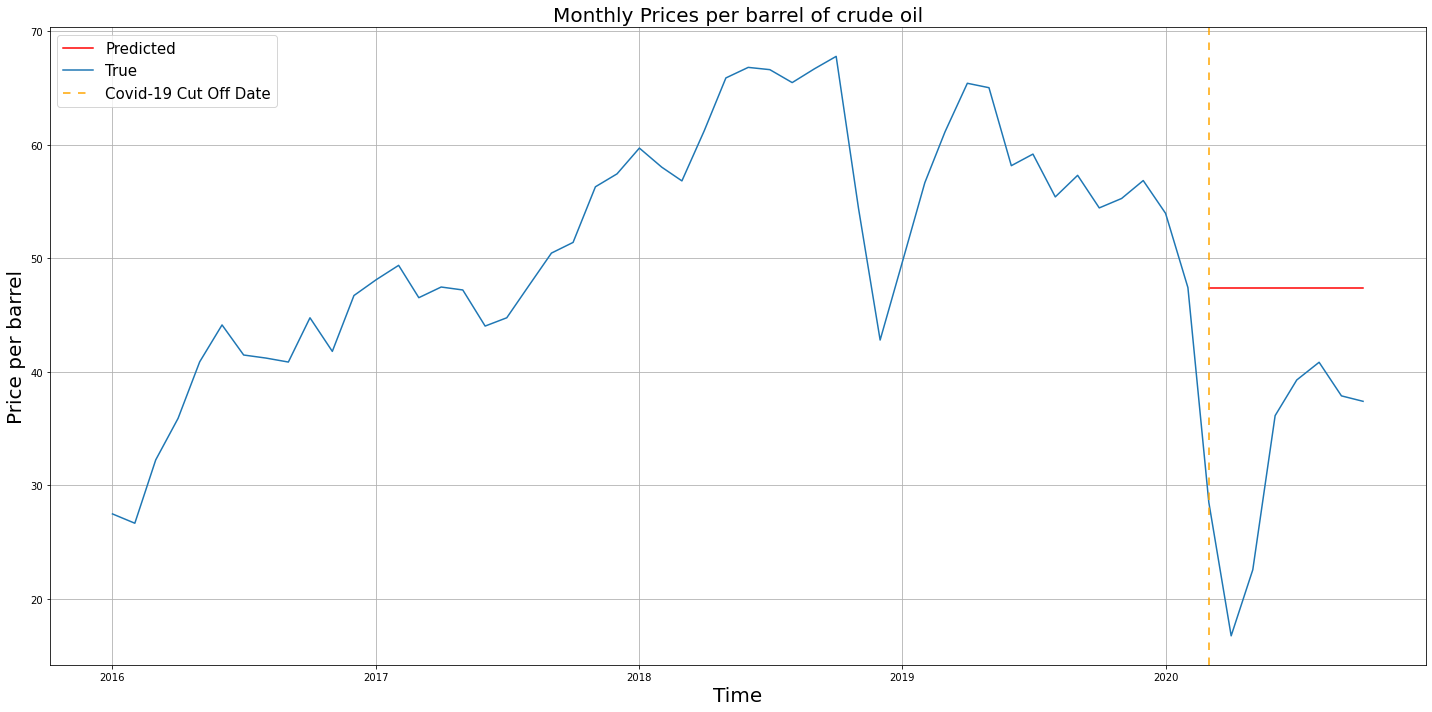

In [12]:
plotregular(final_df.Price, pred=final_df.naive_prediction, predplotlabel='Predicted', trueplotlabel='True')

The MSE: 293.18185000000005 and MAPE:59.98468218720549


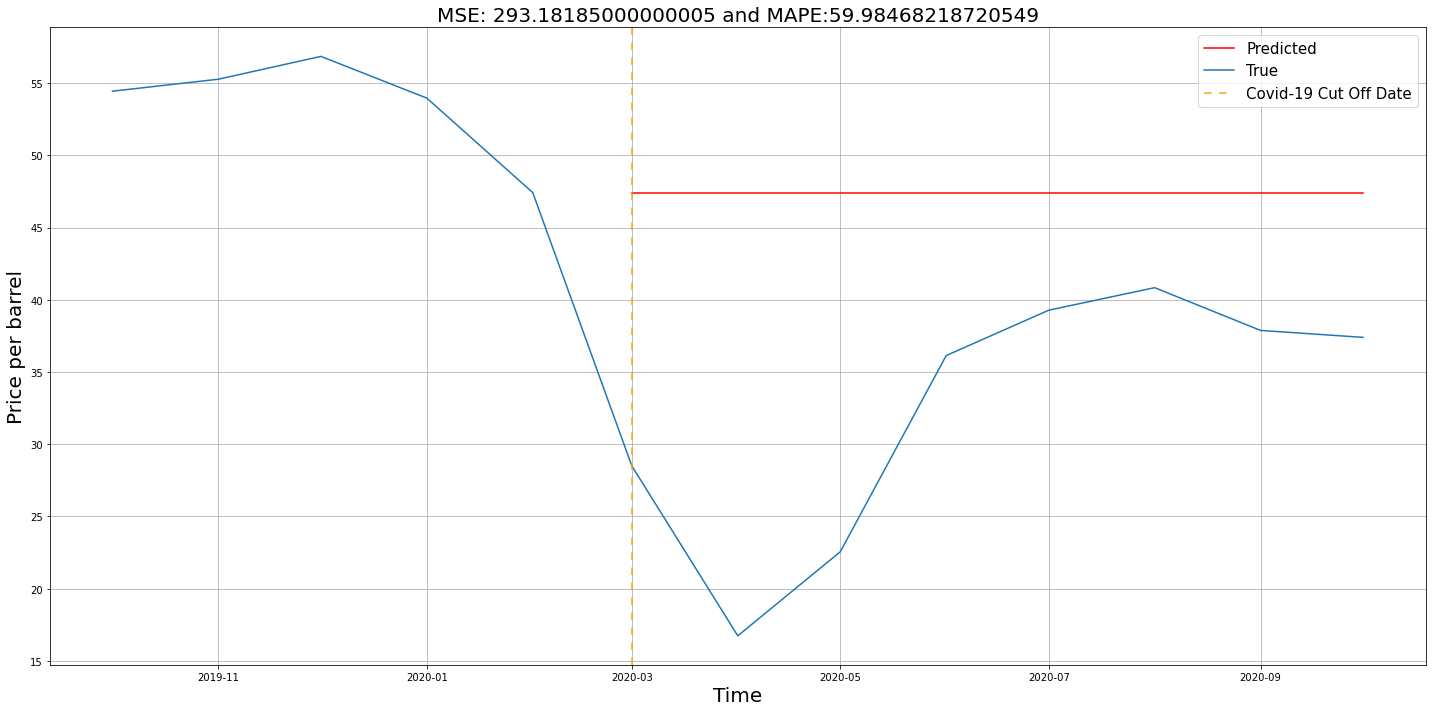

In [13]:
plotregular(final_df.Price, pred=final_df.naive_prediction, predplotlabel='Predicted', trueplotlabel='True', precovid=True, eval=True)

If you look at the top of my graph in the title I have calculated the MSE and MAPE. We see with the no change model that the MAPE is 27.62% and the MSE is 91.98. We see that this is quite high compared to the other models. 

# ii) Anytime series model of your choice 
## ARIMA model
"AR" in ARIMA stands for autoregression model i.e. regression of the time series onto itself. The basically we take previous values with some lag (or several lags) and regress it onto itself.  
"I" in ARIMA stands for order of integration. This is number of nonseasonal differences needed to make the series stationary. In our case, it's just 0 we have a short time period.  
"MA" in ARIMA stands for Moving Average. This models the error of the time series, with the assumption that the current error depends on the previous with some lag.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

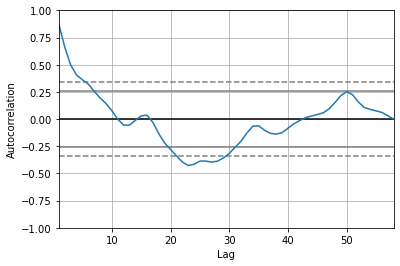

In [14]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
autocorrelation_plot(dfprices)

**Autocorrelation plots** are used for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags.

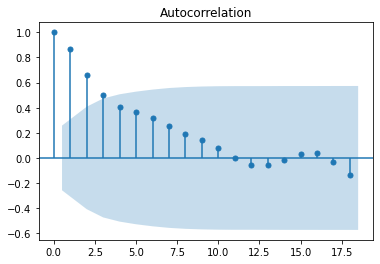

In [15]:
plot_acf(dfprices)
plt.show();

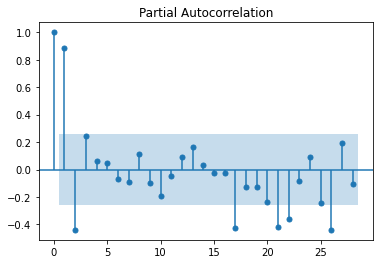

In [16]:
plot_pacf(dfprices, lags=28)
plt.show();

In [17]:
dftrain, dftest = dfprices[dfprices.index < '2020-03-01'], dfprices[dfprices.index >= '2020-03-01']
train, test = dftrain.values, dftest.values
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(3,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat[0])
    obs = test[t]
    history.append(obs)


dfarima = dftest.copy()
dfarima['Price'] = predictions


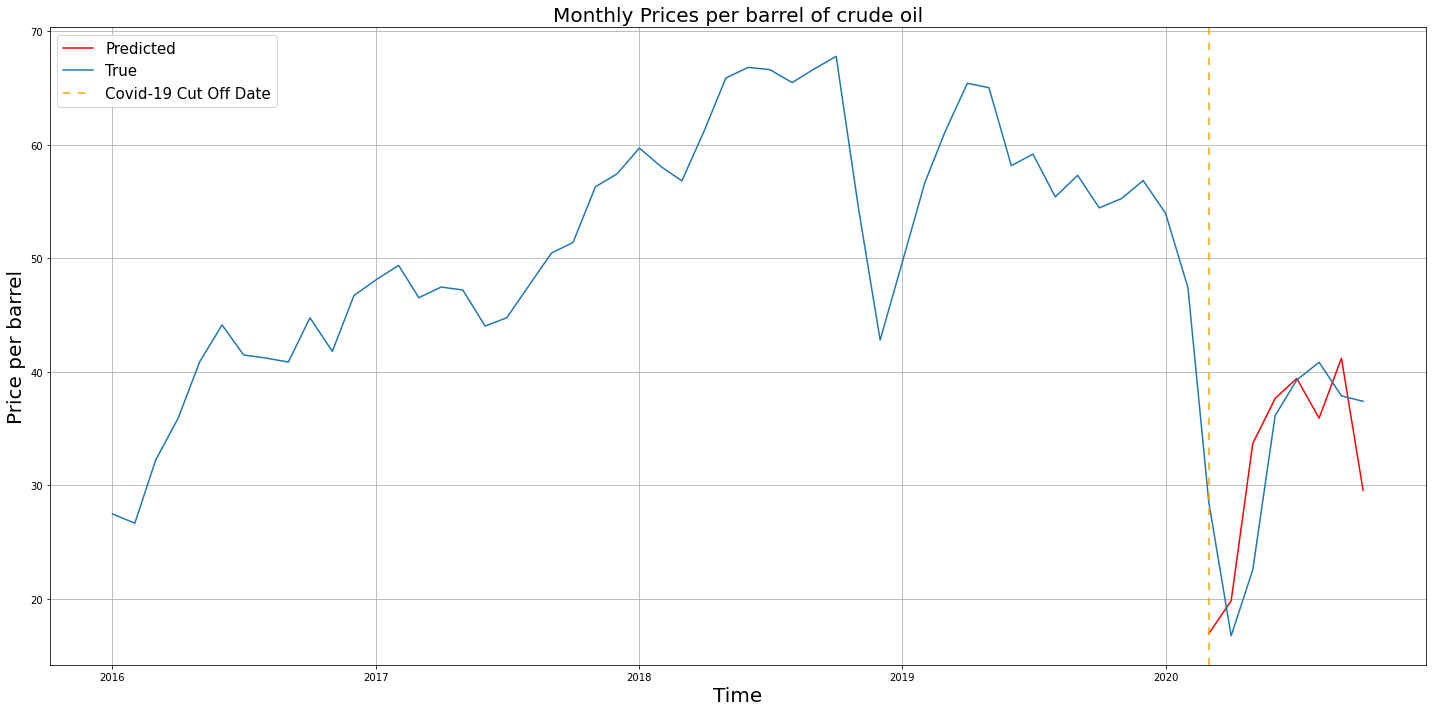

In [18]:
plotregular(dfprices, pred=dfarima, predplotlabel='Predicted', trueplotlabel='True')

The MSE: 45.77162574466248 and MAPE:19.329139636170467


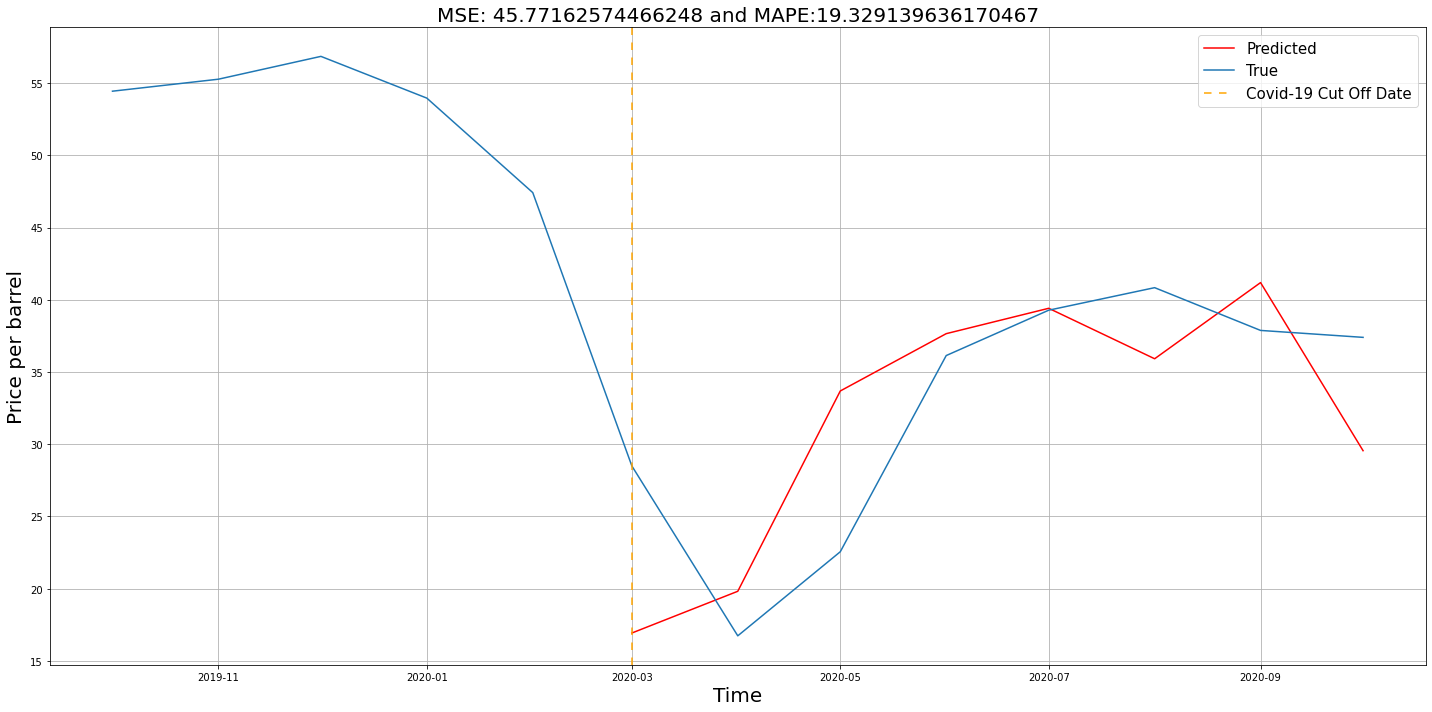

In [19]:
plotregular(dfprices, pred=dfarima, predplotlabel='Predicted', trueplotlabel='True', precovid=True, eval=True)

We see our MSE is 45.77 and our MAPE 19.33%. This is significantly better than our Naive Model in both Criteria. i.e MSE -> -41.93 and MAPE -> -9.15% from the Naive Model. 

# iii) Leading Indicator Model

In [20]:
dfproduction = pd.read_csv(input_path + us_crude_production, index_col="Month", parse_dates=['Month'])
dfproduction = dfproduction[dfproduction.index >= '2016-01-01'] 
dftotal = dfprices.merge(dfproduction, left_index=True, right_index=True)


## Graph of Leading Indicator
The leading Indicator I chose is the monthly production of crude oil in the US. The reason I chose this indicator is because of external research such as  
https://www.investopedia.com/ask/answers/06/oilpriceseconomicindicators.asp  
Here I use lags + indicator and regress it on the next year as the website of Bruce Hansen (example from page 88 in) was suggested in the assignment. I then use that prediction as a lag for the following year, and so on. 


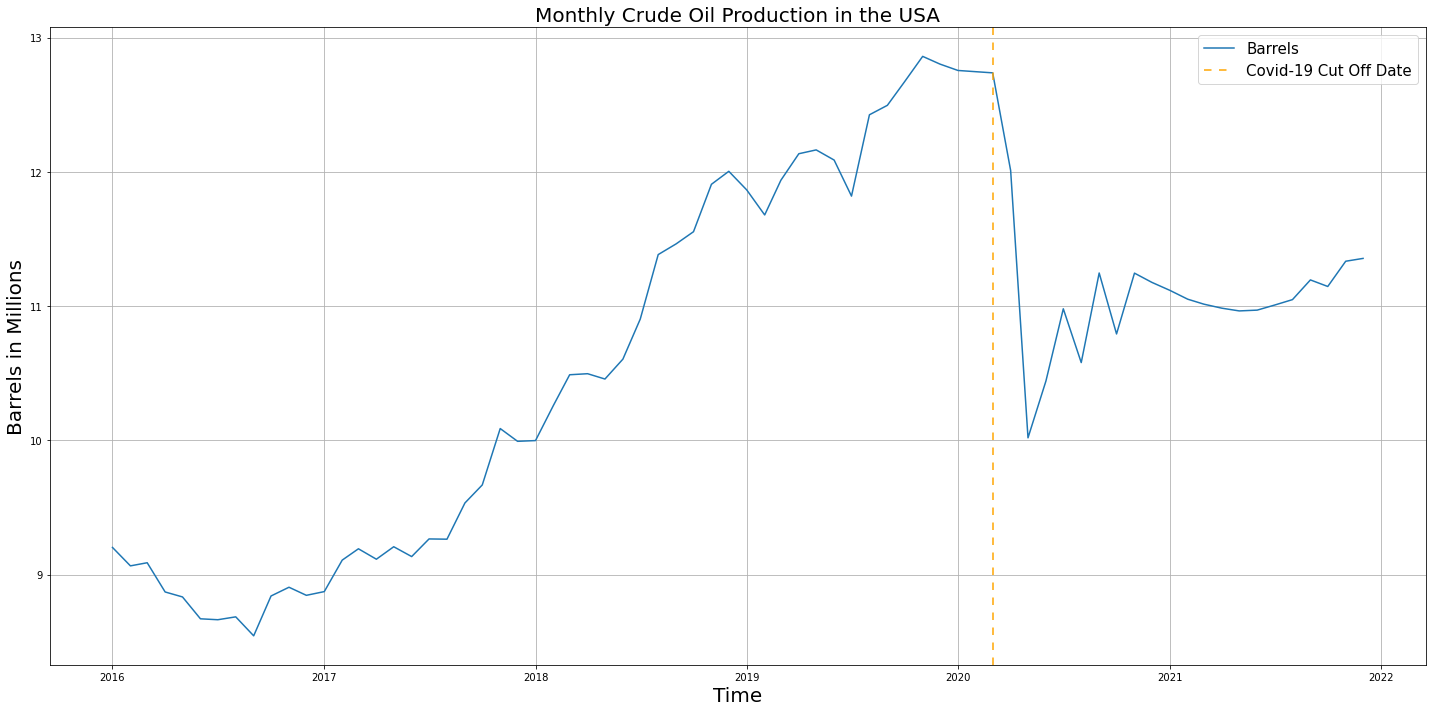

In [21]:
plotregular(dfproduction, title="Monthly Crude Oil Production in the USA", Y_label='Barrels in Millions', trueplotlabel='Barrels')

## Developing Leading Indicator Predictor

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split

In [23]:
def timeseries_train_test_split(X, y):
    # get the index after which test set starts
    test_index = '2020-03-01'
    
    X_train = X[X.index < test_index]
    y_train = y[y.index < test_index]
    X_test = X[X.index >= test_index]
    y_test = y[y.index >= test_index]
    
    return X_train, X_test, y_train, y_test

In [24]:
predictions = []
for i in range(1, 8):
    dftotal["lag_{}".format(i)] = dftotal.Price.shift(i)
y = dftotal.Price
X = dftotal.drop(['Price'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y)


In [25]:
i = 1
predictions = []
for t in range(len(X_test)):
    try:
        Xnew = X_test.dropna()
        lr = LinearRegression()
        lr_fit = lr.fit(X_train, y_train)
        yhat = lr_fit.predict(Xnew)
        predictions.append(yhat)
        temp = X_test.iloc[[-1-i]]
        idx = temp.columns[temp.isna().any()].tolist()
        X_test.loc[X_test.index[-1-i], idx] = predictions[-1]
        i += 1
    except IndexError:
        pass


pred=pd.Series(predictions[-1], index=y_test.index)


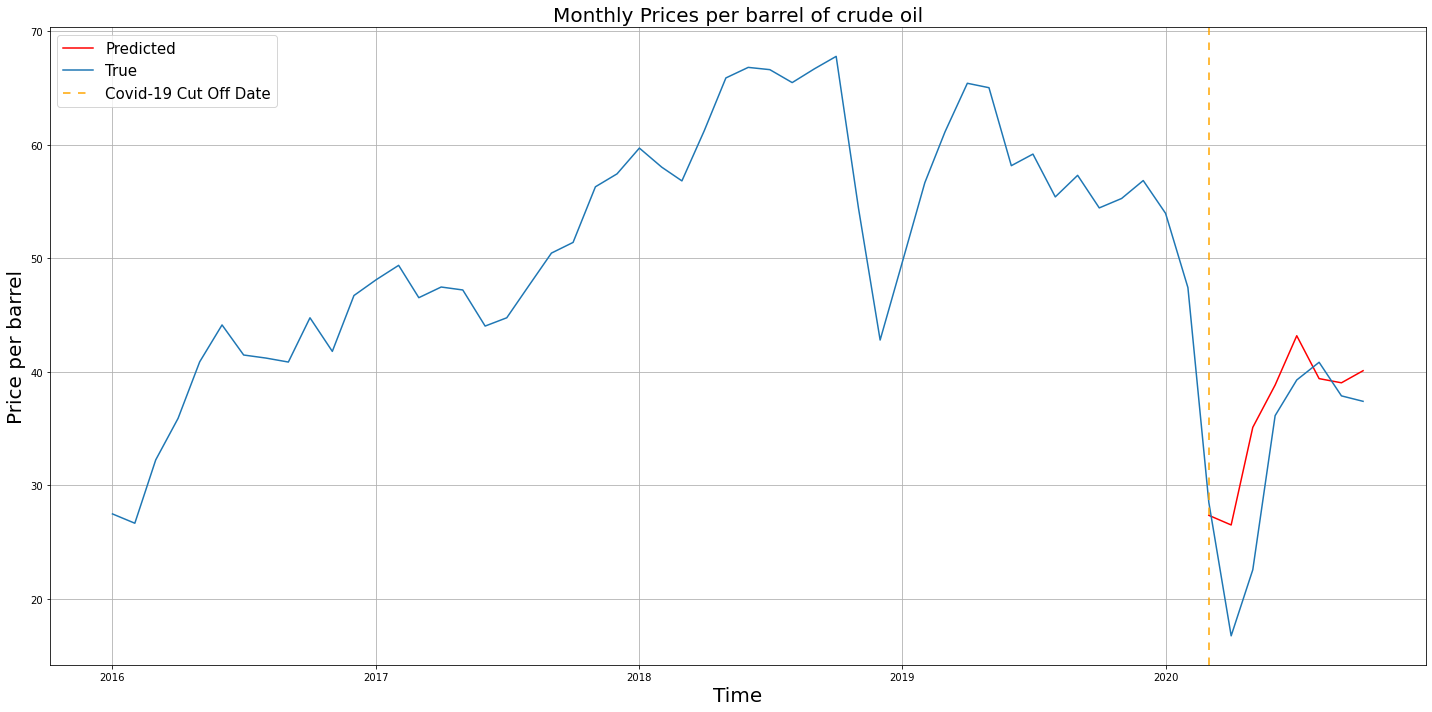

In [26]:
plotregular(dfprices, pred=pred, predplotlabel='Predicted', trueplotlabel='True')

The MSE: 35.90514998980644 and MAPE:33.473192189698786


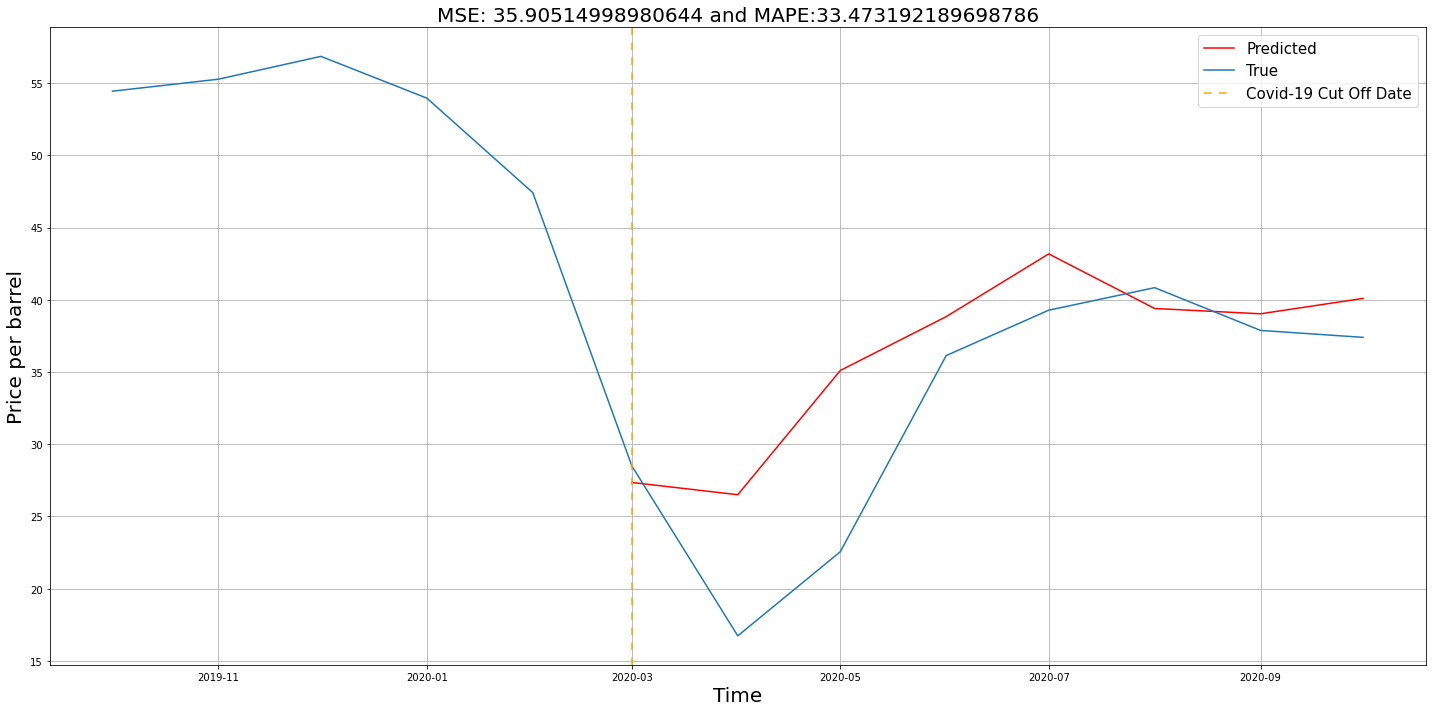

In [27]:
plotregular(dfprices, pred=pred, predplotlabel='Predicted', trueplotlabel='True', precovid=True, eval=True)

We see our MSE is 35.91 and our MAPE:33.47%. This is significantly better than our Naive Model in both Criteria. 

# iv) Professional Forecast
This Professional Forecast was done by the EIA

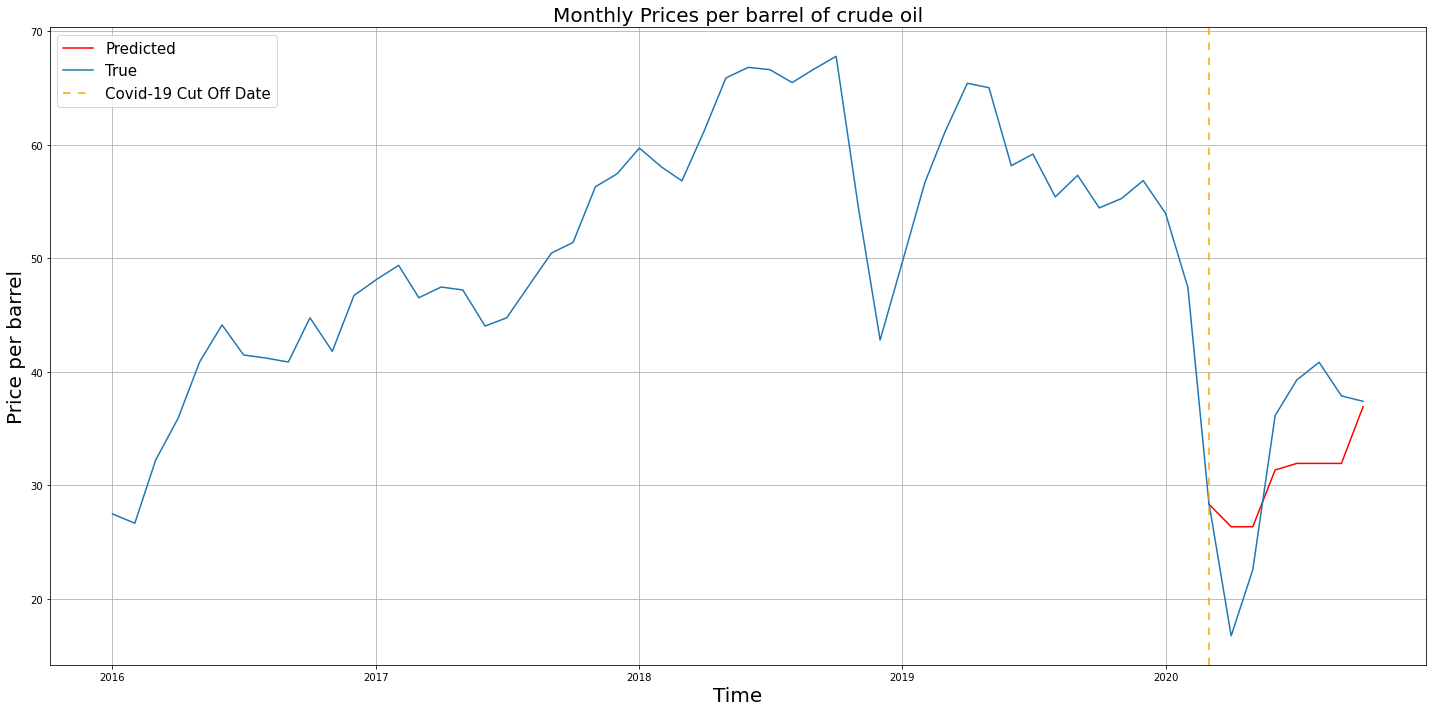

In [28]:
plotregular(dfprices, pred=dfpricesprof, predplotlabel='Predicted', trueplotlabel='True')

The MSE: 37.339600000000026 and MAPE:18.18502768379612


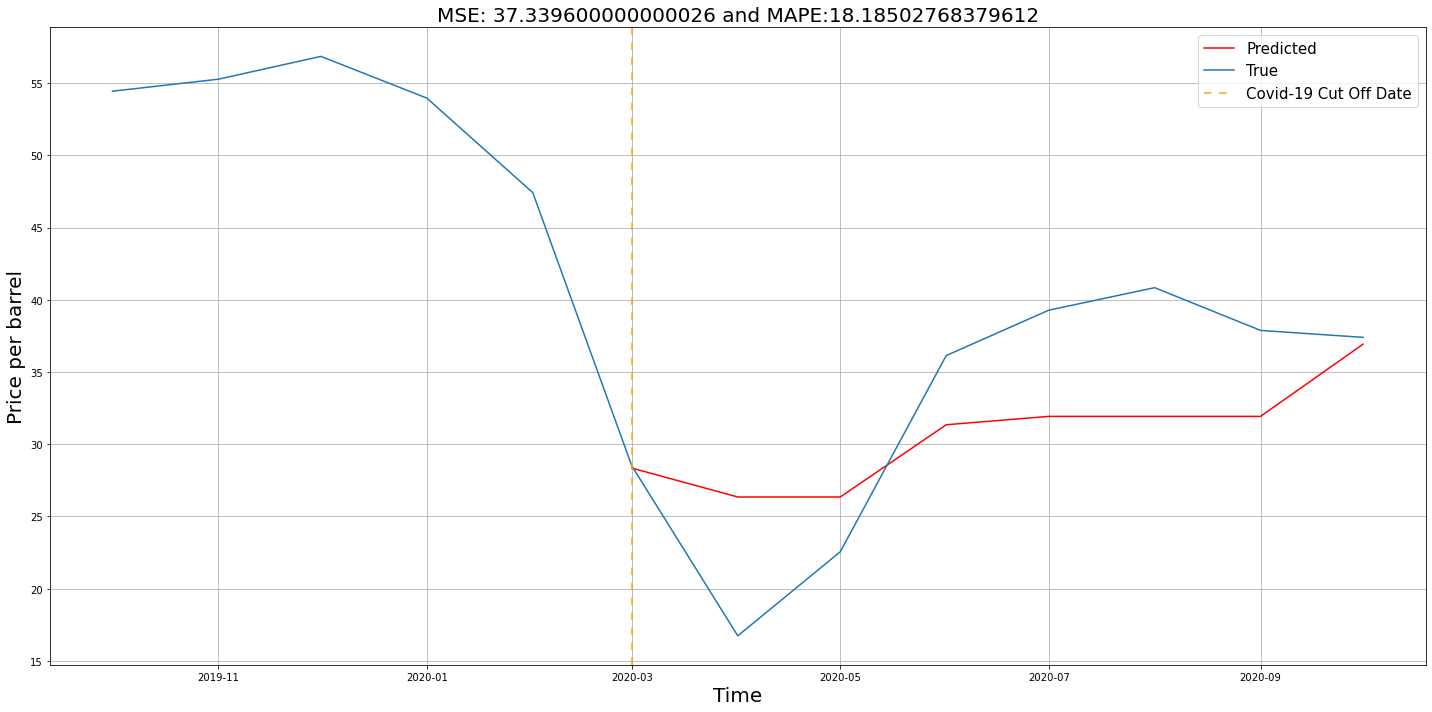

In [29]:
plotregular(dfprices, pred=dfpricesprof, predplotlabel='Predicted', trueplotlabel='True', precovid=True, eval=True)

# Combination Forecasts  
Recalling the paper presented to us in class (Oil Price Forecasts for the Long-Term), the paper suggests when doing combination forecast, "A number of studies have found merit in such approaches, notably for short-run forecast horizons". **I am interested in looking at the long term horizons** for combination forecast and seeing which methods perform better than others.  

I will explore three different forecast combination method's (Simple Averaging, Median, and Bayesian Information Criterion) and apply them on three different combination of models. 

## Breif Intro to the Combination Methods  
- Simple Averaging: The name is quite informing, but it is simply taking the average of all the models assigning equal weights to the models. (2+2+2)/3  
- Median: The name is also self explanitory, but it is middle number in a sorted, ascending or descending, list of numbers
- Bayesian Information Criterion: Let n denote  the  sample  size, k(m)  the  number  of  unknown  parameters  of model m,  and sigma^2(m)  the  estimate  of  the  variance  of  the  error  term. The  BIC  weight  is  defined  as: exp(−0.5[n*ln(sigma^2(m)) + k(m)*ln(n)]).  This gives a weight to the models, then we simply average them.


In [30]:
from math import log
from math import exp
def combinationaverageforecast(a, b, c):
    a = a[a.index >= '2020-03-01'].values
    b = b[b.index >= '2020-03-01'].values
    c = c[c.index >= '2020-03-01'].values
    data = np.array([a, b, c])
    data = np.average(data, axis=0)
    return pd.Series(data, index=y_test.index) 

def combinationmedianforecast(a, b, c):
    a = a[a.index >= '2020-03-01'].values
    b = b[b.index >= '2020-03-01'].values
    c = c[c.index >= '2020-03-01'].values
    data = np.array([a, b, c])
    data = np.median(data, axis=0)
    return pd.Series(data, index=y_test.index) 

def calculate_bic(n, mse, num_params):
    ran = dfprices[dfprices.index >= '2020-03-01']
    mse = mean_squared_error(ran.values, mse)
    bic = n * log(mse) + num_params * log(n)
    return (exp(1/bic))

def combinationbicforecast(a, b, c, aparams=1, bparams=1, cparams=1):
    a = a[a.index >= '2020-03-01'].values
    b = b[b.index >= '2020-03-01'].values
    c = c[c.index >= '2020-03-01'].values
    abic = calculate_bic(len(a), a, aparams)
    bbic = calculate_bic(len(b), b, bparams)
    cbic = calculate_bic(len(c), c, cparams)
    data = np.array([abic*a, bbic*b, cbic*c])
    data = np.average(data, axis=0)
    return pd.Series(data, index=y_test.index) 


## Combining the arima, leading indicator, and professional 

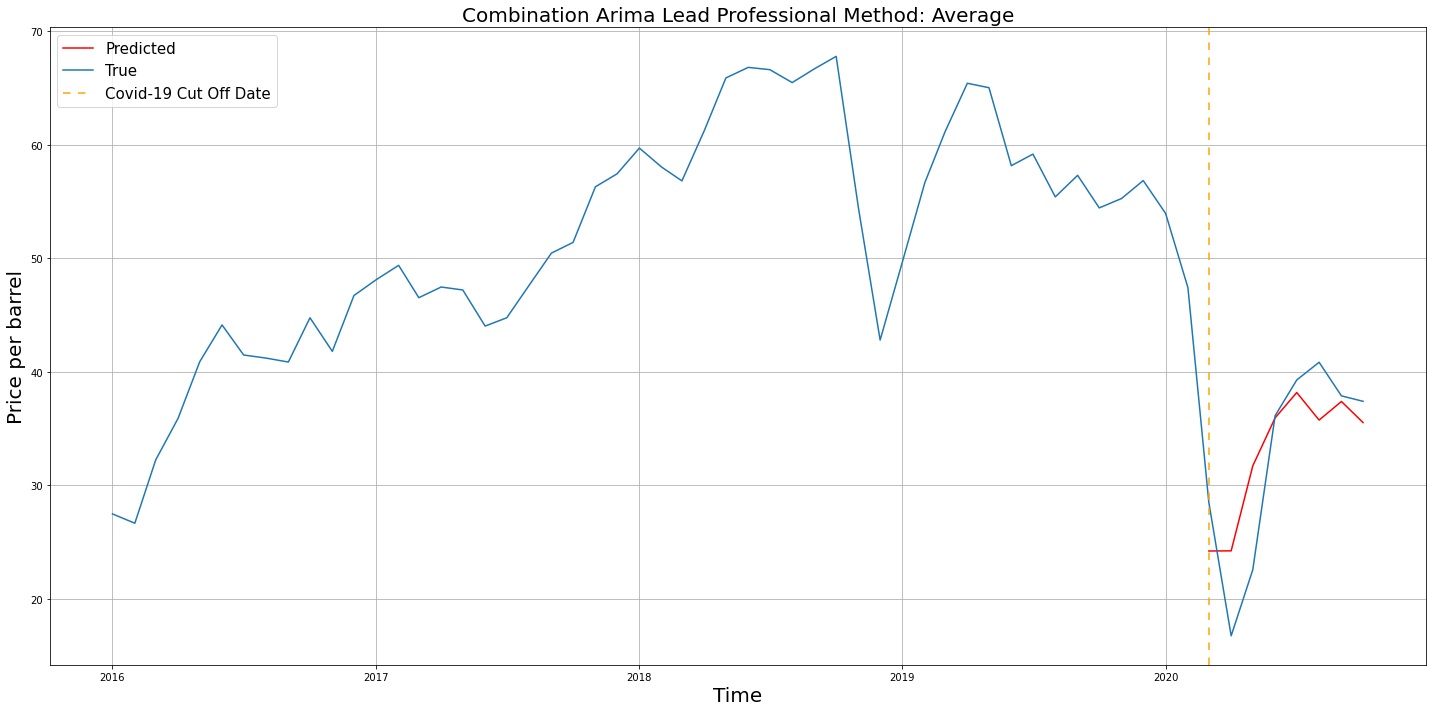

In [31]:
arima_lead_prof = combinationaverageforecast(dfarima['Price'], pred, dfpricesprof['Price'])
arima_lead_prof_median = combinationmedianforecast(dfarima['Price'], pred, dfpricesprof['Price'])
arima_lead_prof_bic = combinationbicforecast(dfarima['Price'], pred, dfpricesprof['Price'])
plotregular(dfprices, pred=arima_lead_prof, predplotlabel='Predicted', trueplotlabel='True', title='Combination Arima Lead Professional Method: Average')

The MSE: 23.64678098398111 and MAPE:29.761701034229837


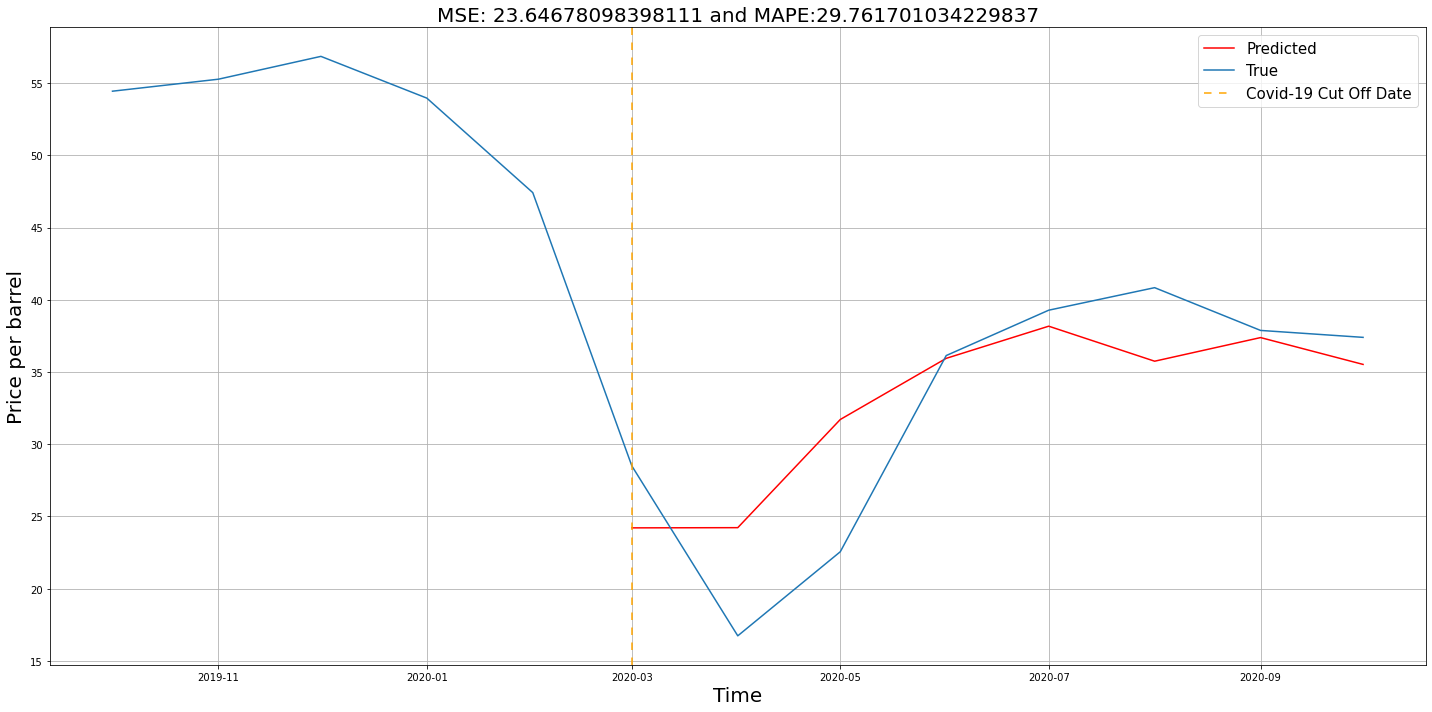

In [32]:
plotregular(dfprices, pred=arima_lead_prof, predplotlabel='Predicted', trueplotlabel='True', precovid=True, eval=True)

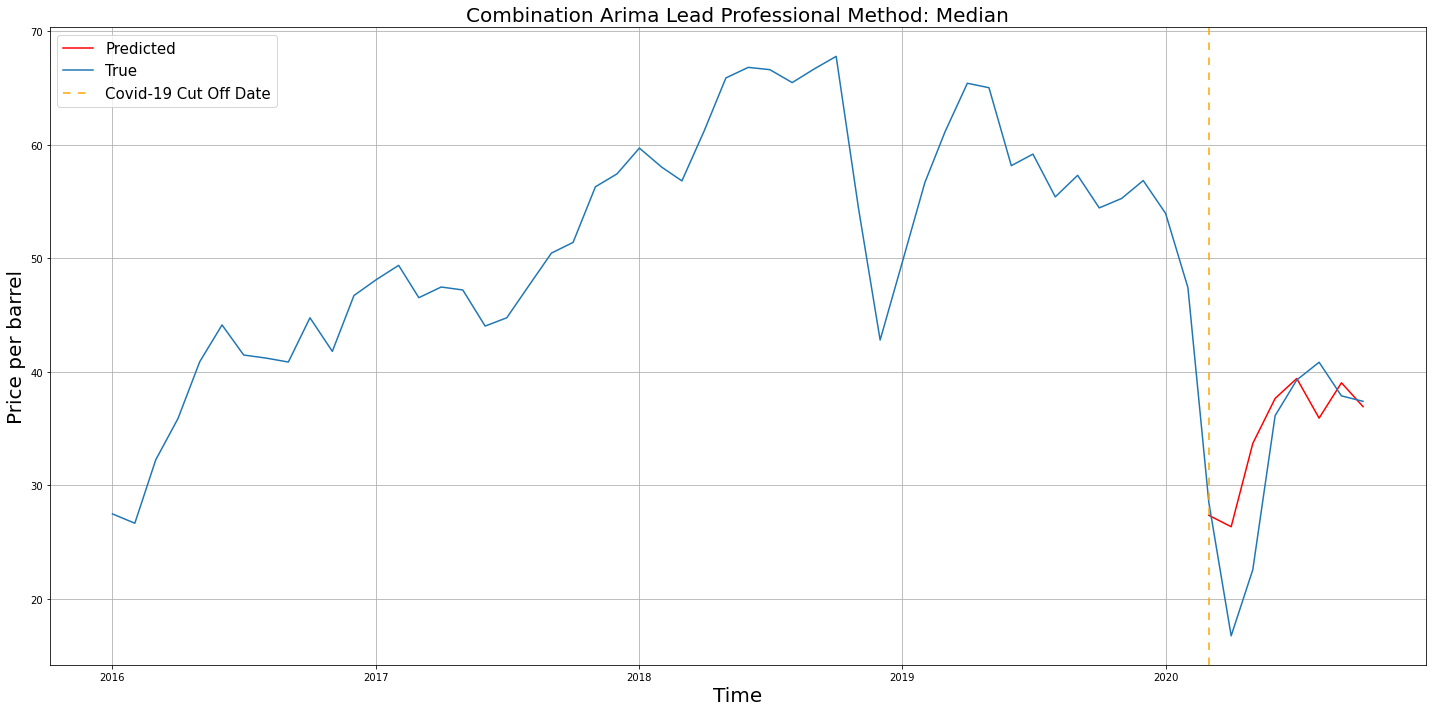

In [33]:
plotregular(dfprices, pred=arima_lead_prof_median, predplotlabel='Predicted', trueplotlabel='True', title='Combination Arima Lead Professional Method: Median')

The MSE: 30.699020102470776 and MAPE:30.278277424616896


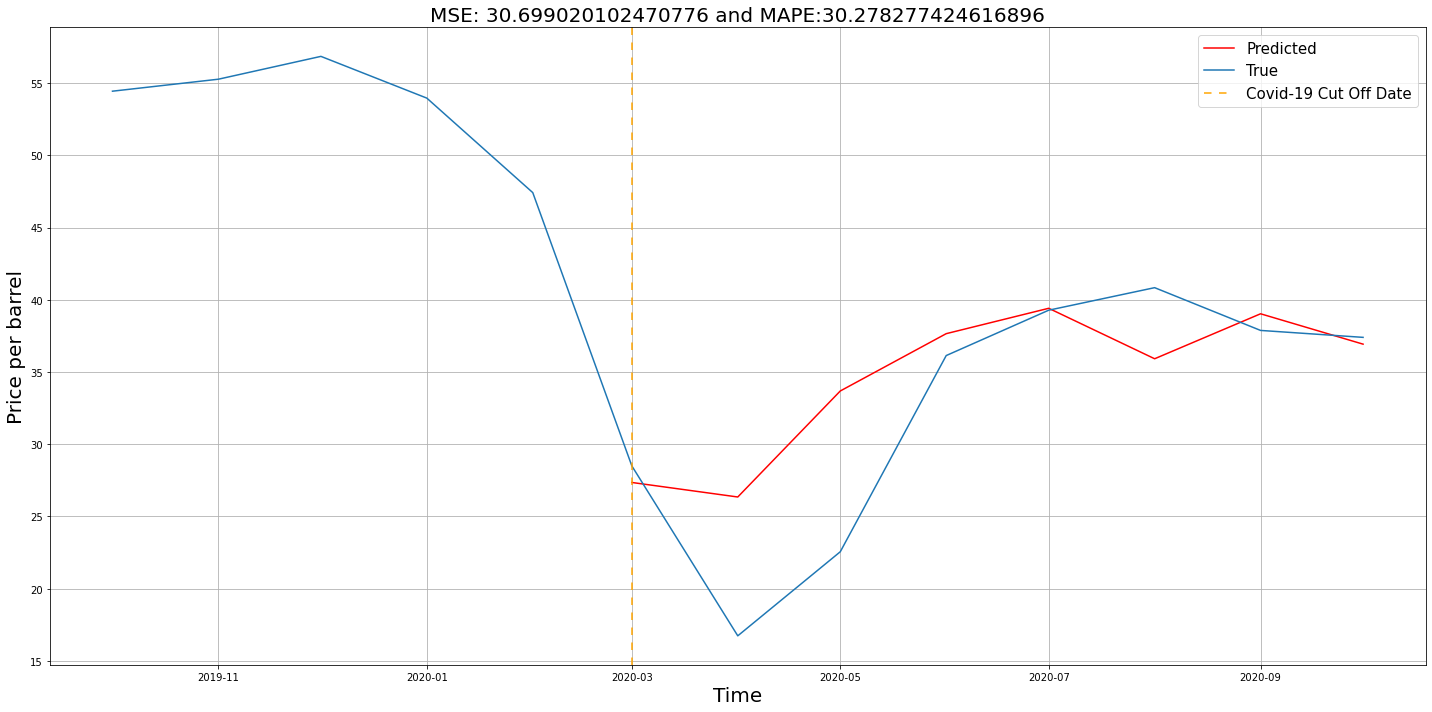

In [34]:
plotregular(dfprices, pred=arima_lead_prof_median, predplotlabel='Predicted', trueplotlabel='True', precovid=True, eval=True)

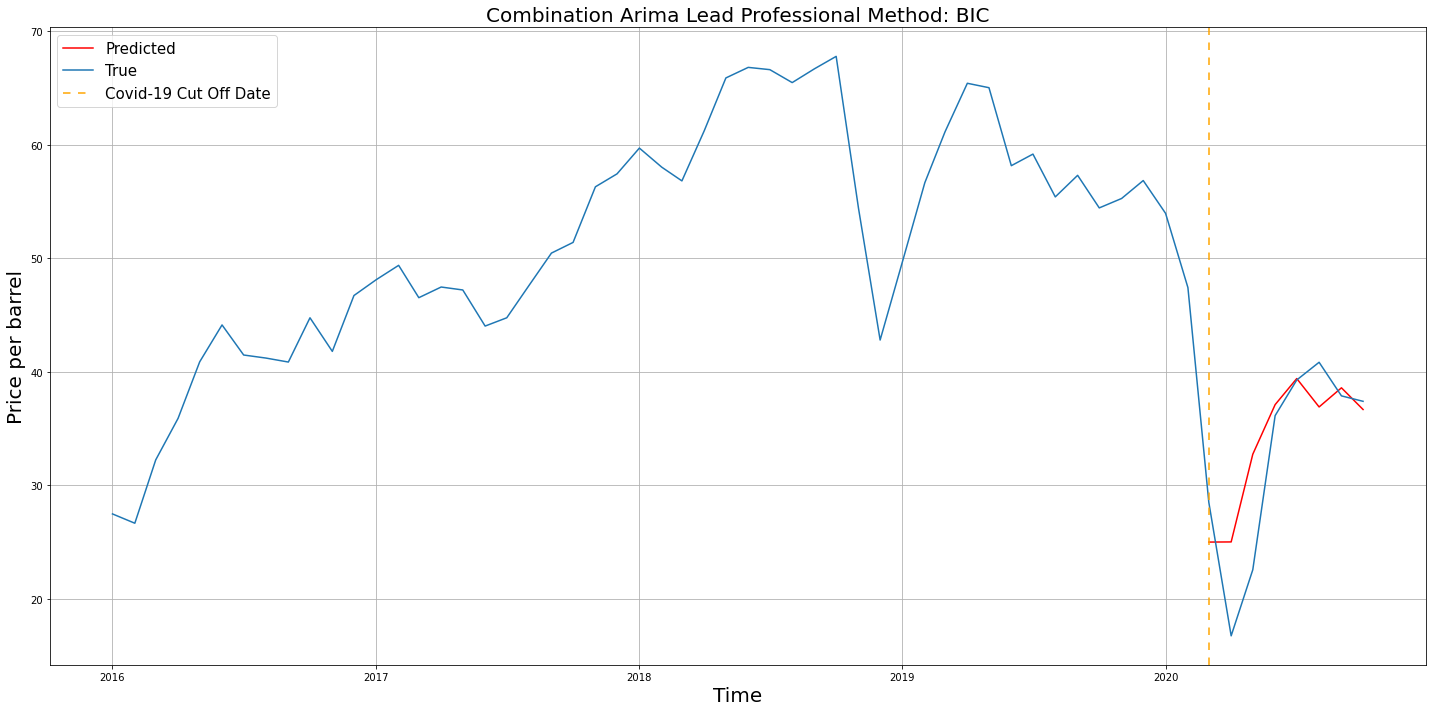

In [35]:
plotregular(dfprices, pred=arima_lead_prof_bic, predplotlabel='Predicted', trueplotlabel='True', title='Combination Arima Lead Professional Method: BIC')

The MSE: 25.21922578258472 and MAPE:30.480949590620455


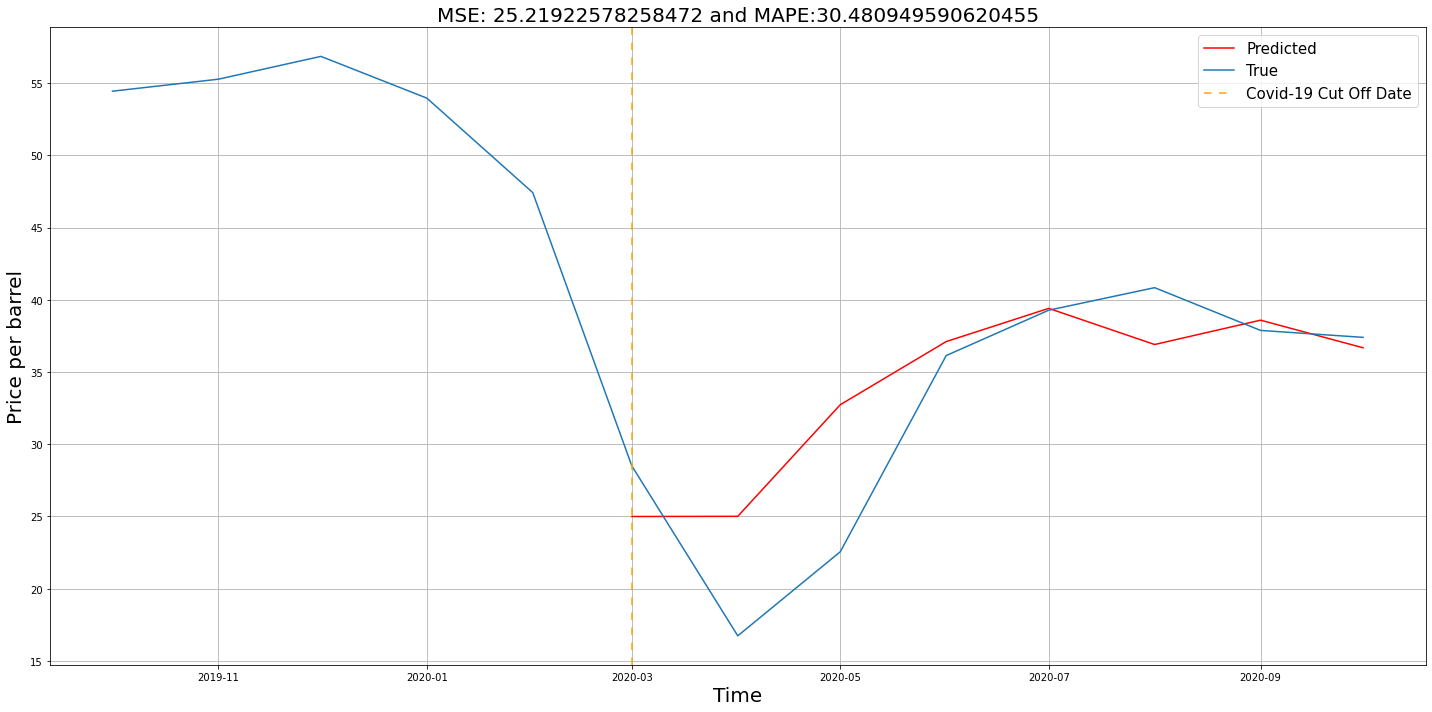

In [36]:
plotregular(dfprices, pred=arima_lead_prof_bic, predplotlabel='Predicted', trueplotlabel='True', precovid=True, eval=True)

## Combining Naive, Leading indicator, Professional

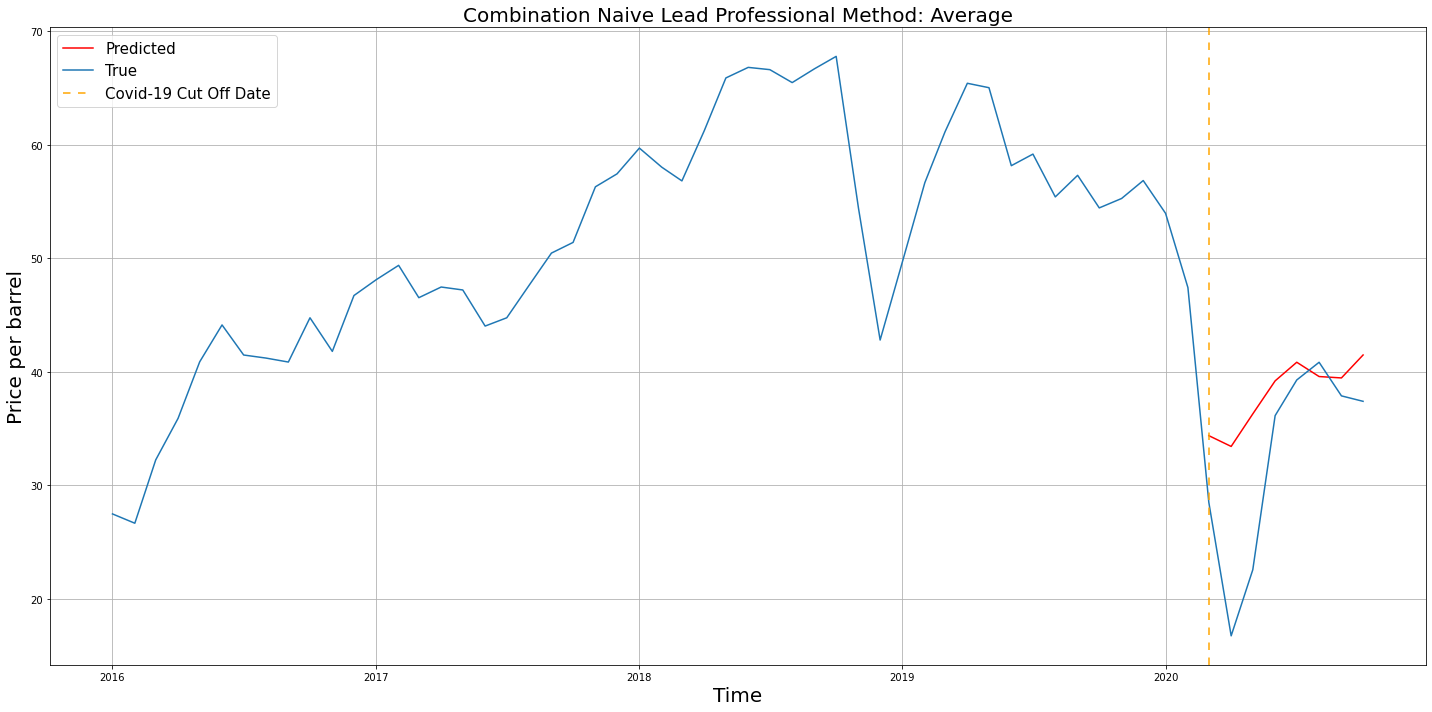

In [37]:
naive_lead_prof = combinationaverageforecast(final_df['naive_prediction'], pred, dfpricesprof['Price'])
naive_lead_prof_median = combinationmedianforecast(final_df['naive_prediction'], pred, dfpricesprof['Price'])
naive_lead_prof_bic = combinationbicforecast(final_df['naive_prediction'], pred, dfpricesprof['Price'])
plotregular(dfprices, pred=naive_lead_prof, predplotlabel='Predicted', trueplotlabel='True', title='Combination Naive Lead Professional Method: Average')

The MSE: 66.75754197796108 and MAPE:33.17263807559713


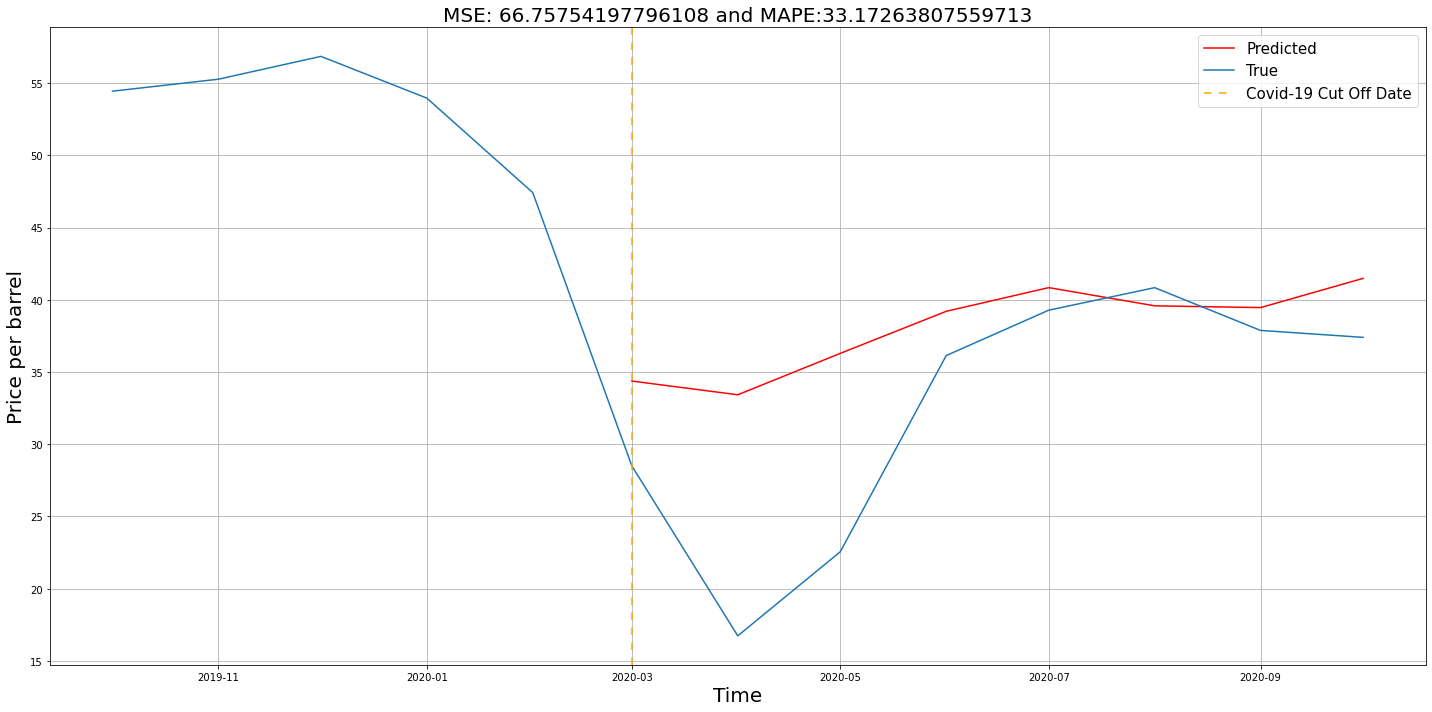

In [38]:
plotregular(dfprices, pred=naive_lead_prof, predplotlabel='Predicted', trueplotlabel='True', precovid=True, eval=True)

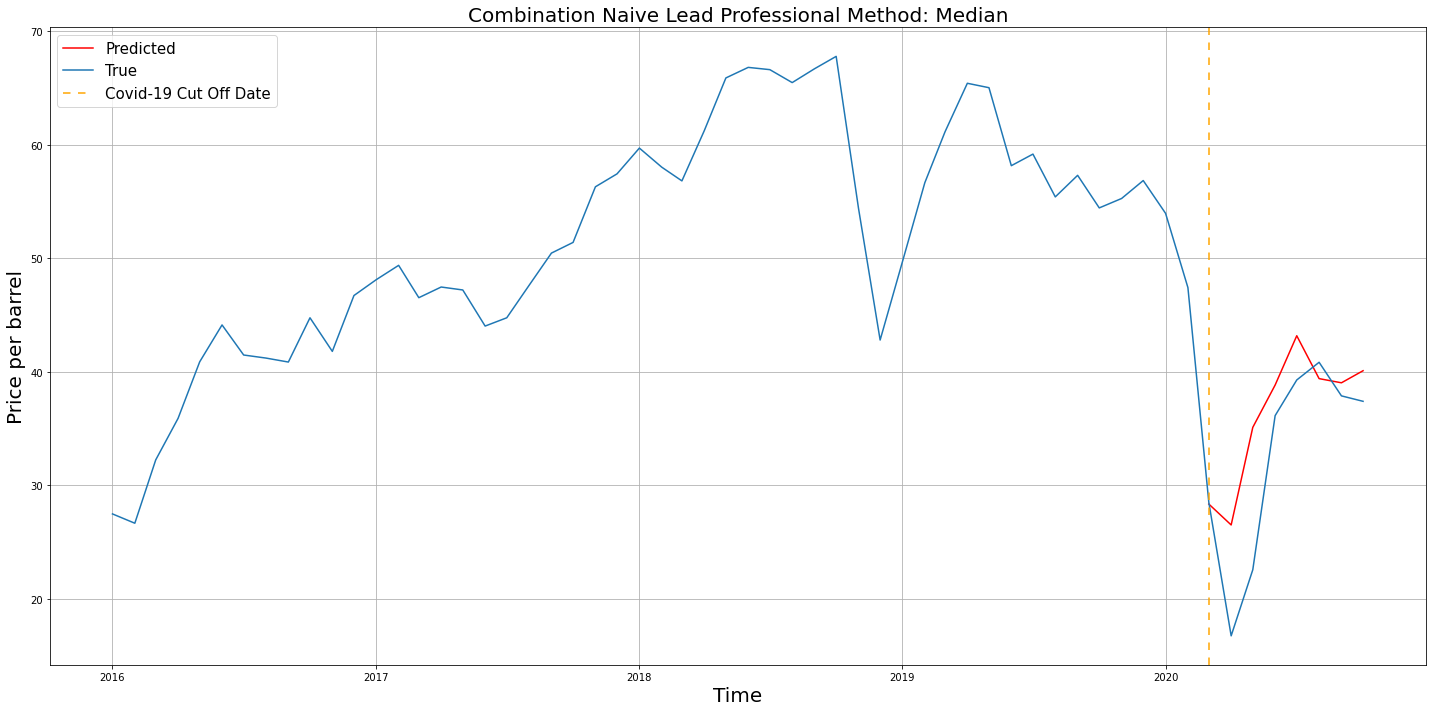

In [39]:
plotregular(dfprices, pred=naive_lead_prof_median, predplotlabel='Predicted', trueplotlabel='True', title='Combination Naive Lead Professional Method: Median')

The MSE: 35.74432400670366 and MAPE:33.37723117616412


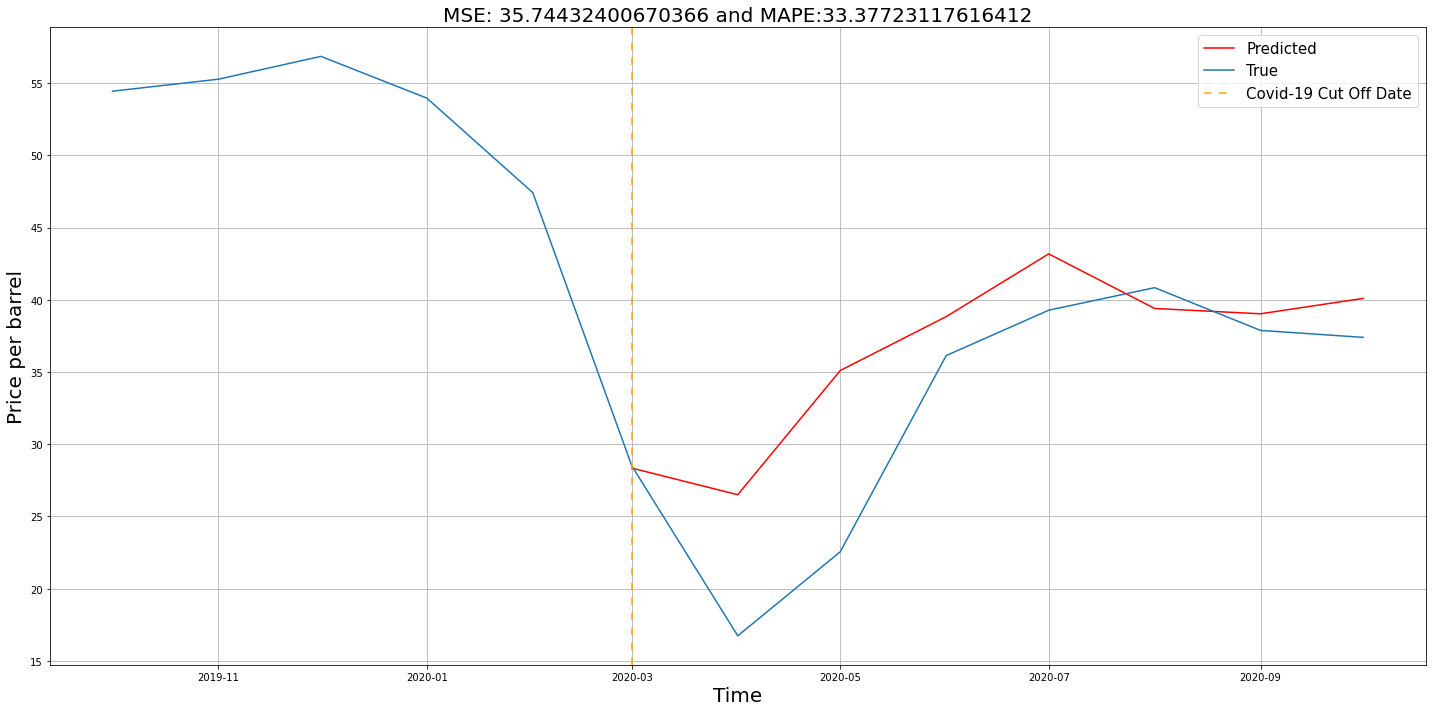

In [40]:
plotregular(dfprices, pred=naive_lead_prof_median, predplotlabel='Predicted', trueplotlabel='True', precovid=True, eval=True)

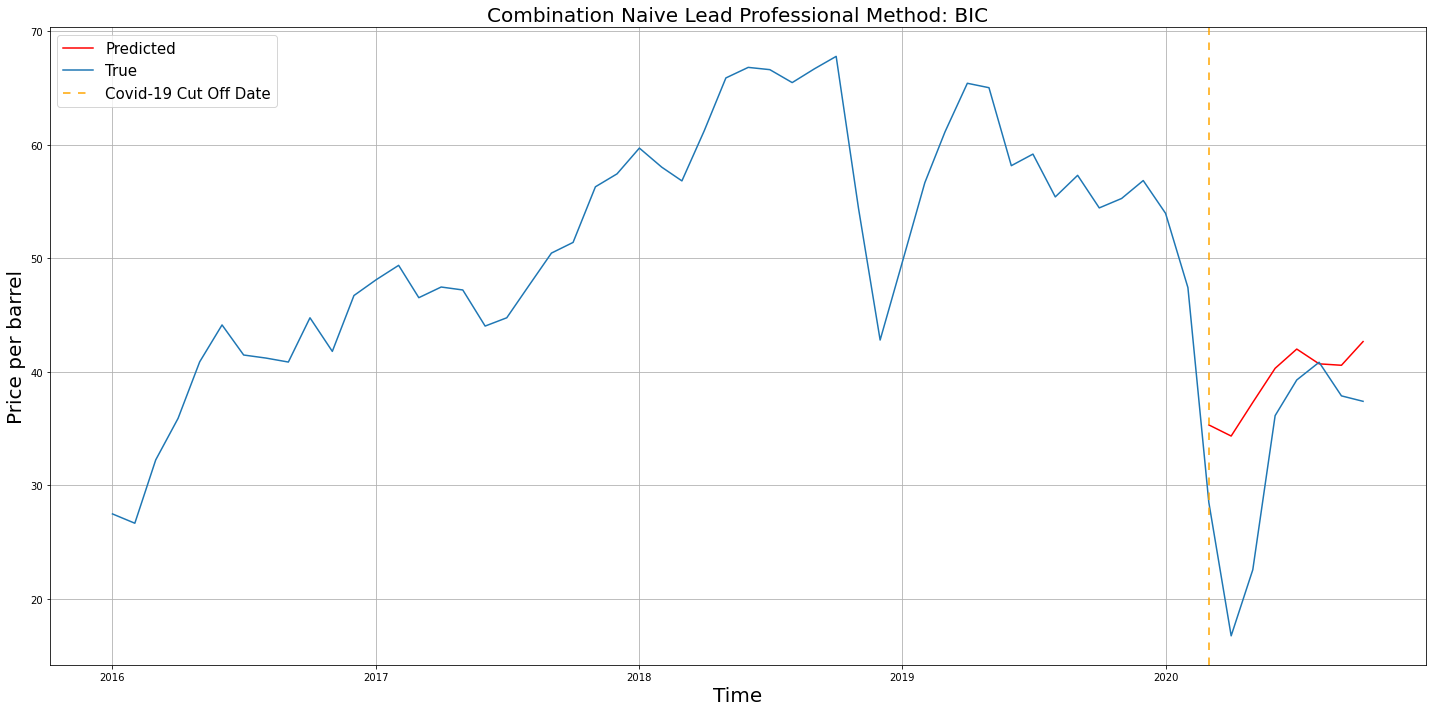

In [41]:
plotregular(dfprices, pred=naive_lead_prof_bic, predplotlabel='Predicted', trueplotlabel='True', title='Combination Naive Lead Professional Method: BIC')

The MSE: 79.18728147941451 and MAPE:35.43238050467525


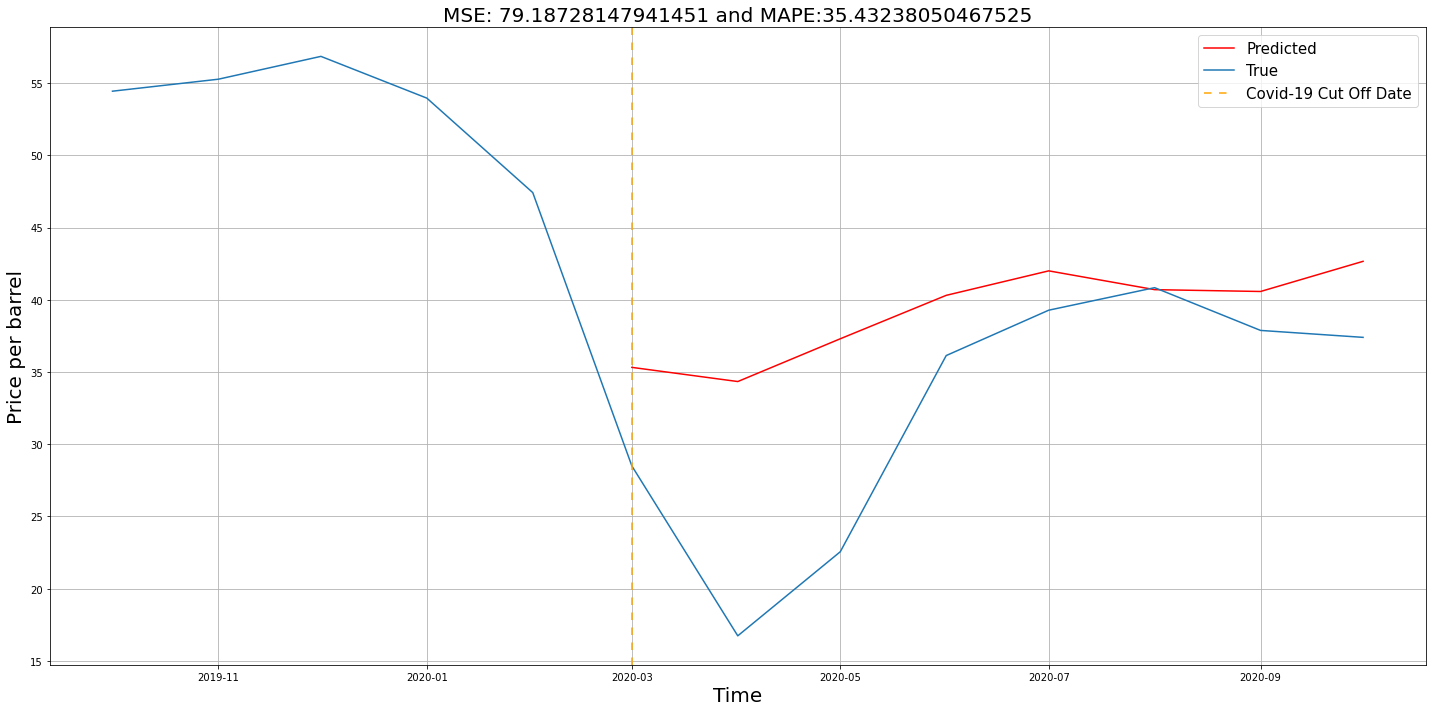

In [42]:
plotregular(dfprices, pred=naive_lead_prof_bic, predplotlabel='Predicted', trueplotlabel='True',precovid=True, eval=True)

## Combining Naive, Arima, Professional

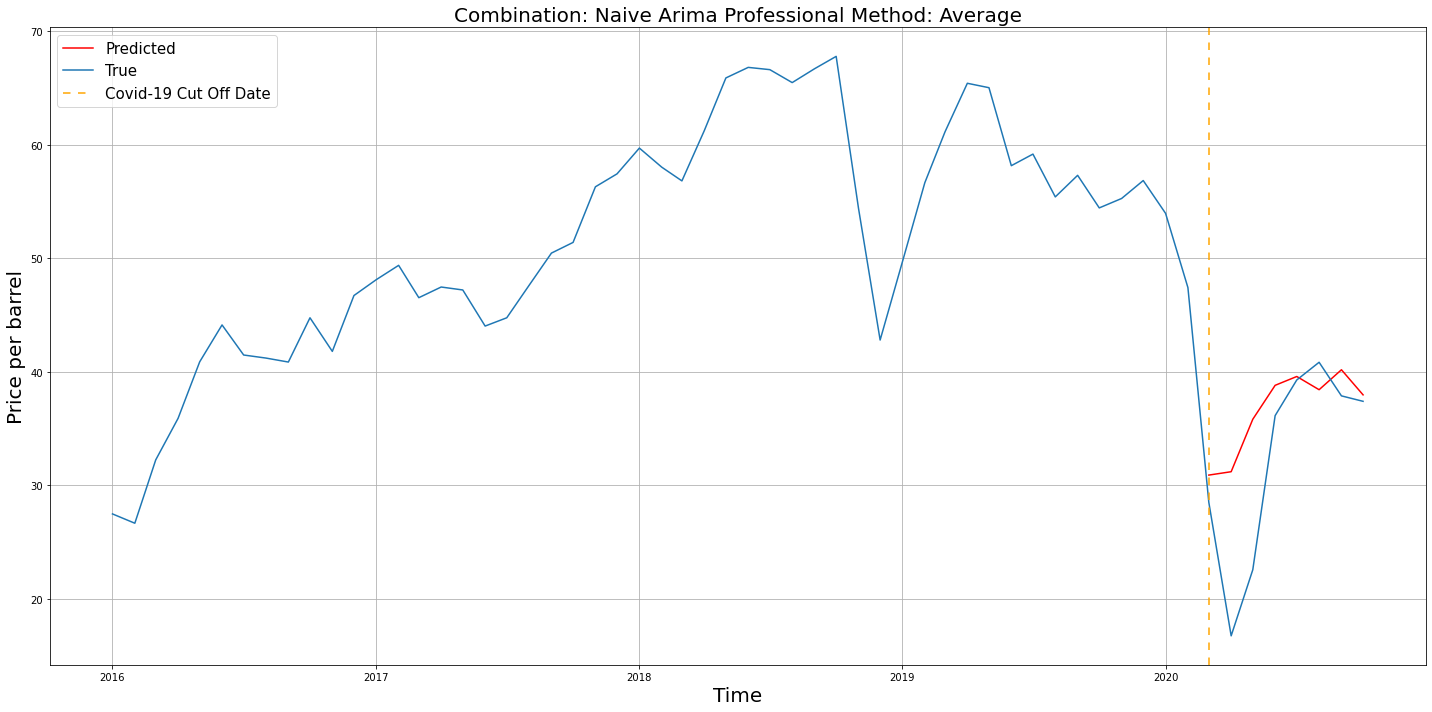

In [43]:
naive_arima_prof = combinationaverageforecast(final_df['naive_prediction'], dfarima['Price'], dfpricesprof['Price'])
naive_arima_prof_median = combinationmedianforecast(final_df['naive_prediction'], dfarima['Price'], dfpricesprof['Price'])
naive_arima_prof_bic = combinationbicforecast(final_df['naive_prediction'], dfarima['Price'], dfpricesprof['Price'])
plotregular(dfprices, pred=naive_arima_prof, predplotlabel='Predicted', trueplotlabel='True', title='Combination: Naive Arima Professional Method: Average')

The MSE: 51.161356636357226 and MAPE:31.298948789646207


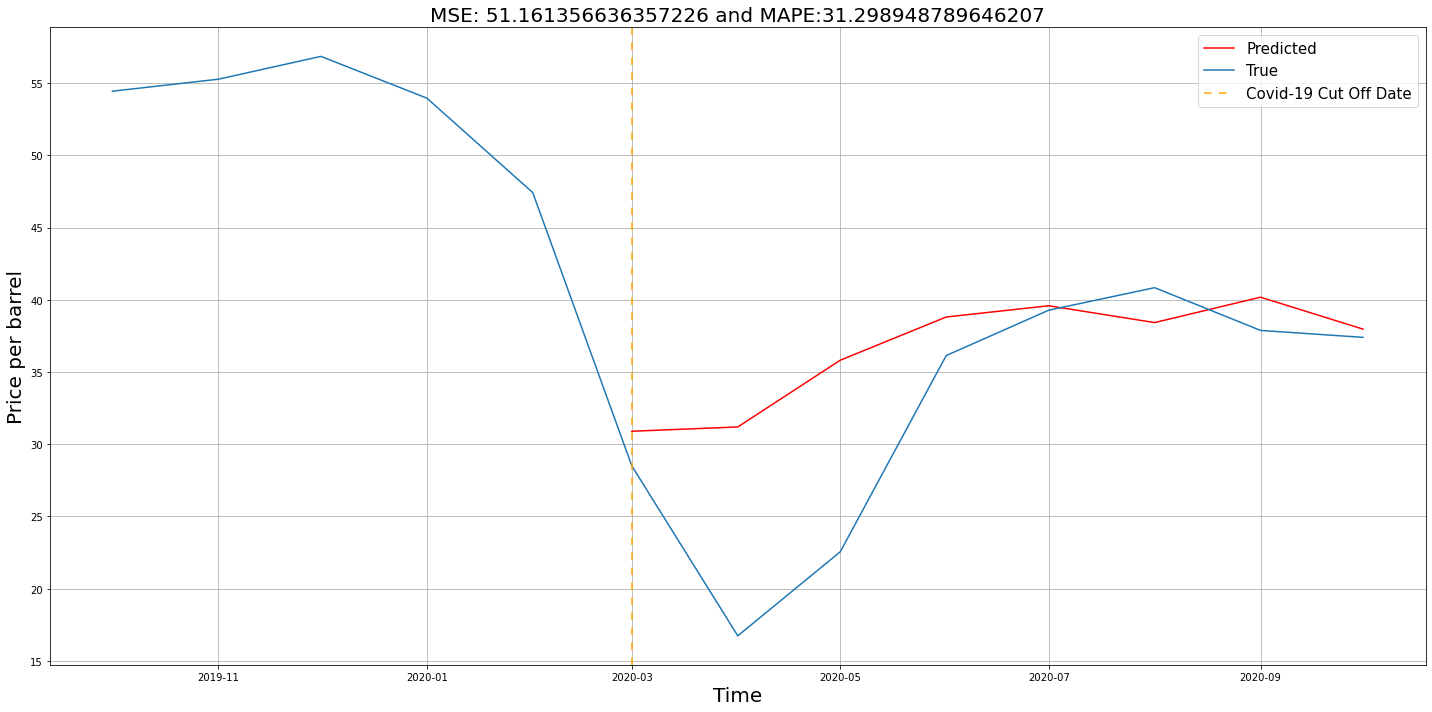

In [44]:
plotregular(dfprices, pred=naive_arima_prof, predplotlabel='Predicted', trueplotlabel='True', eval=True, precovid=True)

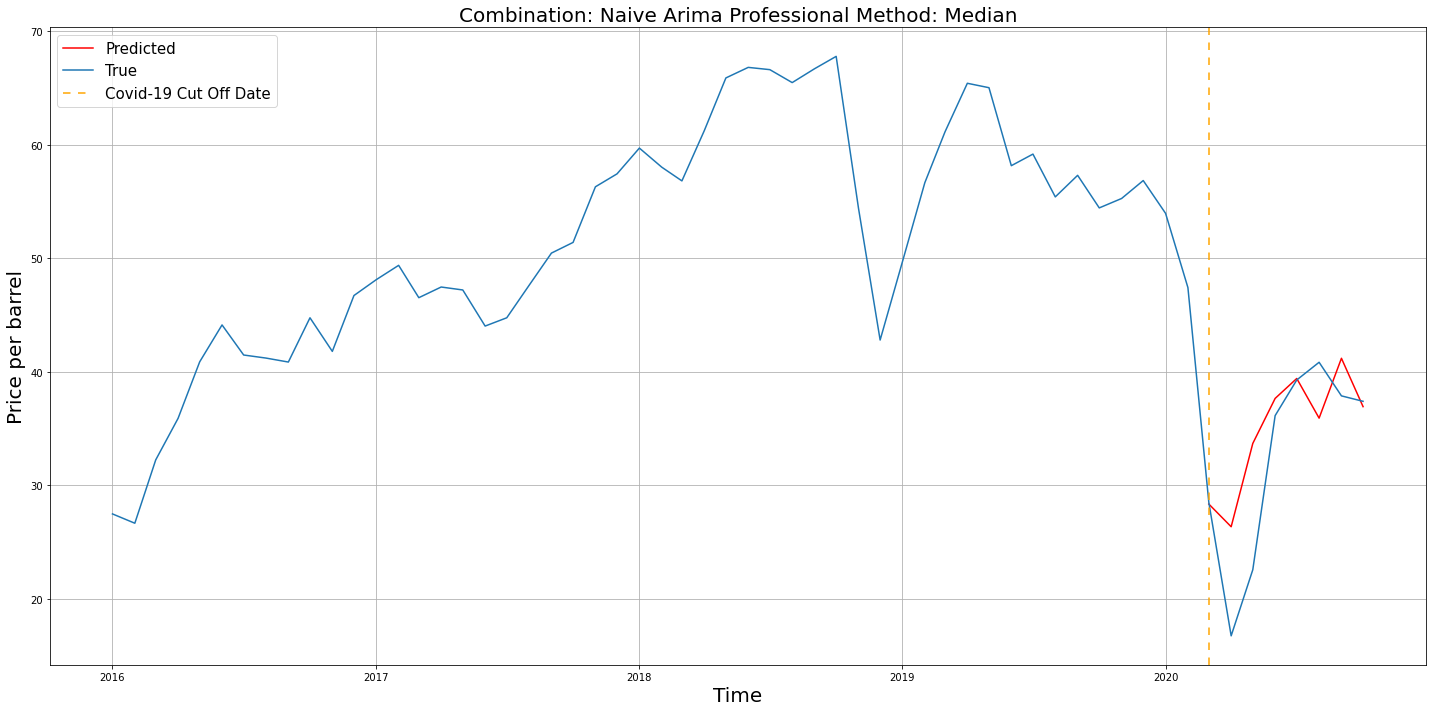

In [45]:
plotregular(dfprices, pred=naive_arima_prof_median, predplotlabel='Predicted', trueplotlabel='True', title='Combination: Naive Arima Professional Method: Median')

The MSE: 31.743113642122722 and MAPE:30.93499025685788


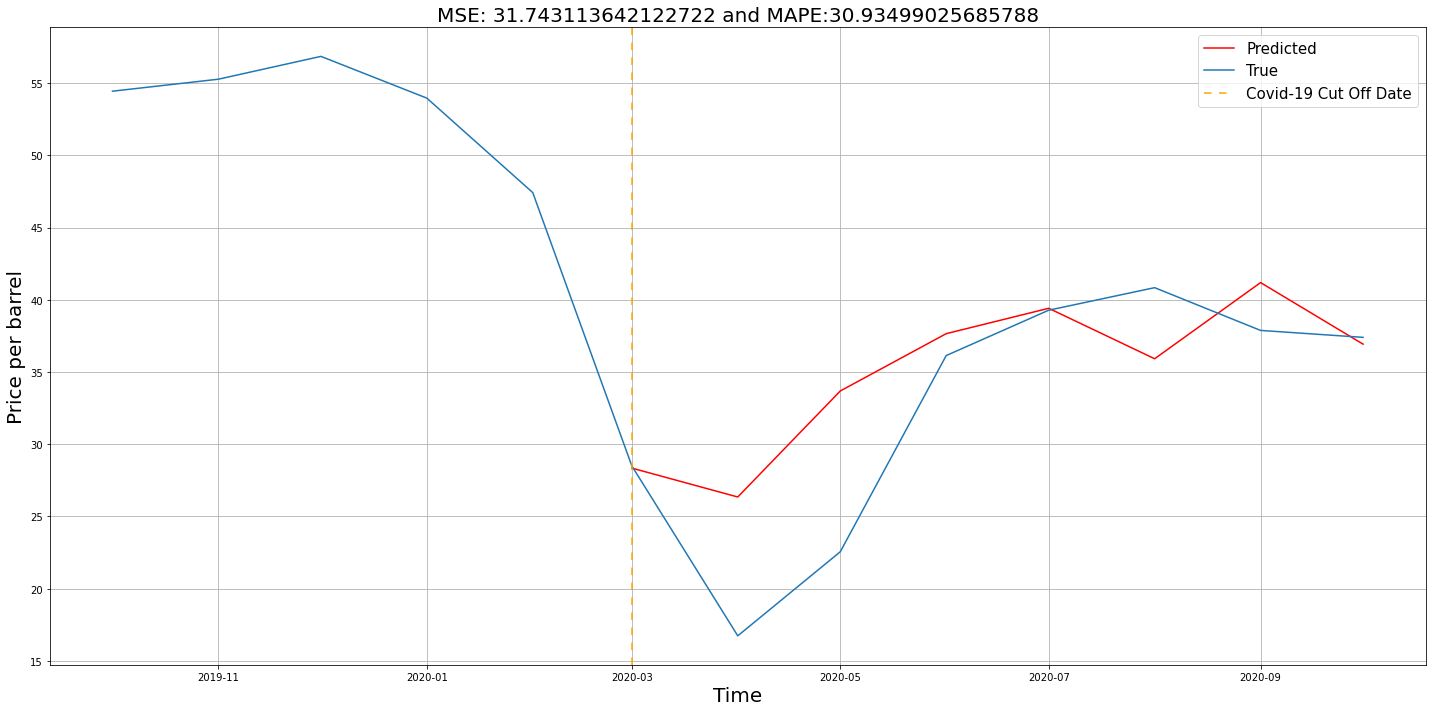

In [46]:
plotregular(dfprices, pred=naive_arima_prof_median, predplotlabel='Predicted', trueplotlabel='True', eval=True, precovid=True)

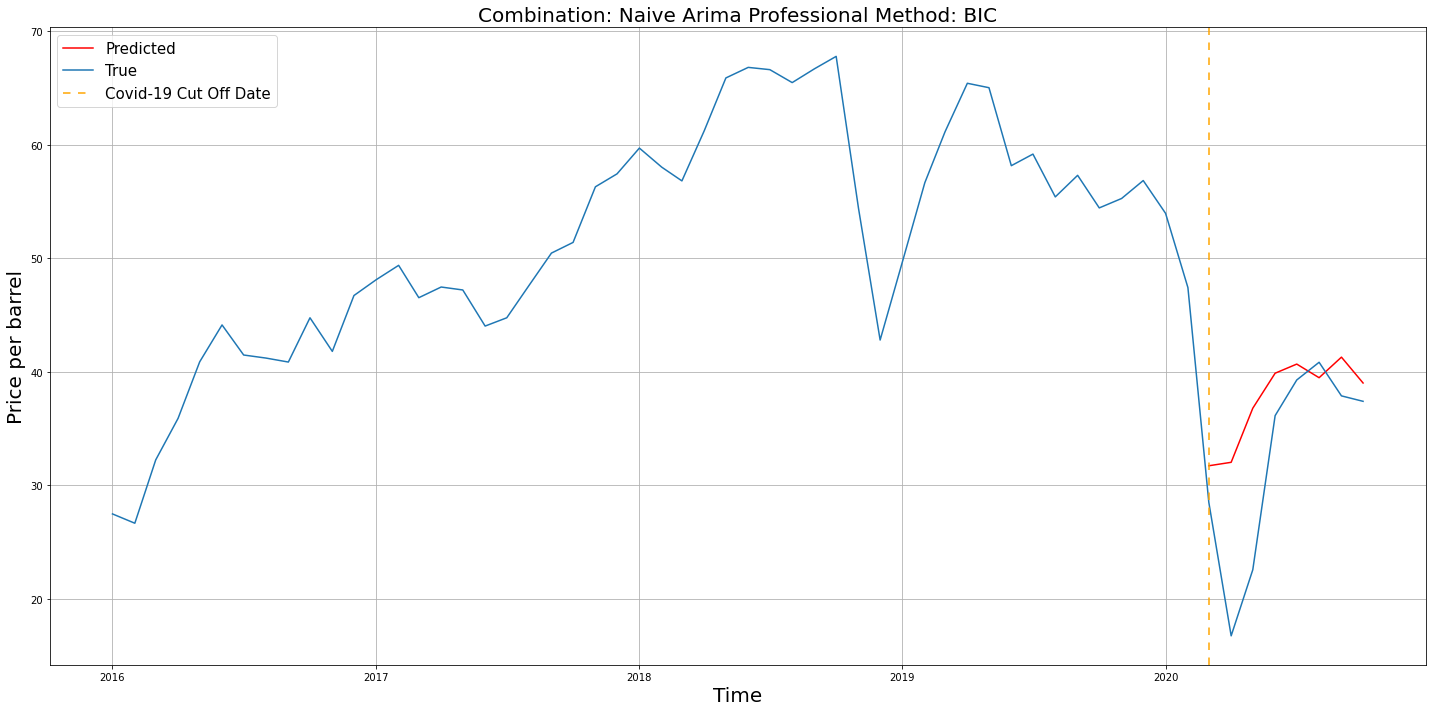

In [47]:
plotregular(dfprices, pred=naive_arima_prof_bic, predplotlabel='Predicted', trueplotlabel='True', title='Combination: Naive Arima Professional Method: BIC')

The MSE: 59.83255365668157 and MAPE:33.09094257428939


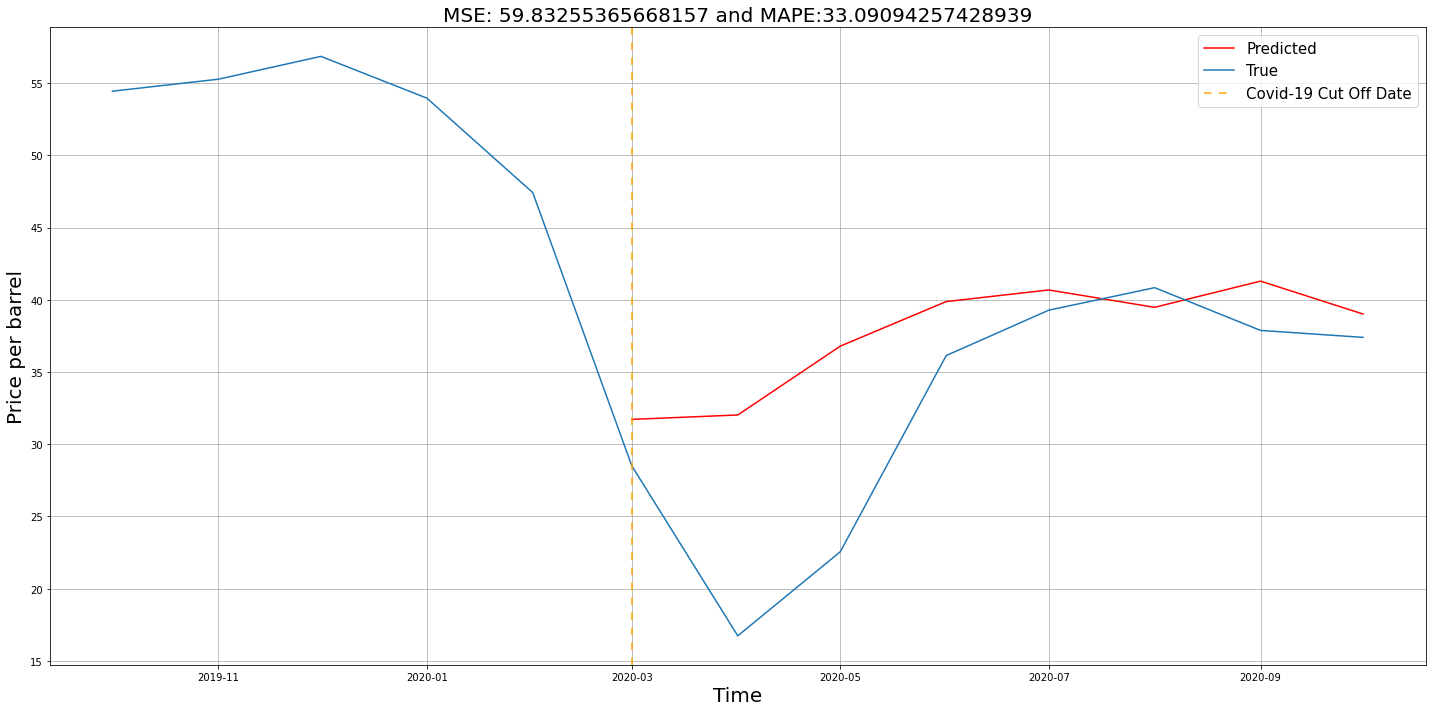

In [48]:
plotregular(dfprices, pred=naive_arima_prof_bic, predplotlabel='Predicted', trueplotlabel='True', eval=True, precovid=True)

# Research Question

> If the models you propose are estimated pre-covid and forecasted post-covid till the end of the sample you considered, which of the models outperforms the professional forecasts (it is OK if all models fail in this regard), and does combining all models with the professional forecast improve the resulting forecast? Use at least two evaluation criteria. Explain whether the professional forecast you considered has been updated post covid (the answer to this question should be in the documentation of the forecast youselect).

## Collecting our Results
### Models
- Naive: The MSE: 293.18 and MAPE:59.98    
- Arima: The MSE: 45.77 and MAPE:19.33    
- Lead:  The MSE: 35.91 and MAPE:33.47  
- Prof:  The MSE: 37.34 and MAPE:18.19    

From our results specifically looking at the models section we see that the Professional models performs has the best score if we treat the two criteria we use evenly weighted. The Proffessional model has the best MAPE score, while our leading indicator model performs the best according the the MSE criteria but does not perform that well if you look specifically at MAPE. Our Naive model when forecasting 7 months out performs the worst it both criteria. The Arima model has the second worst MSE, but performs very well when looking at MAPE. Taking the average of the criteria scores, we see that the best performing models are Professional > Arima > Leading indicator > Naive in that order. None of our models beat the professional forecast taking account of both criteria. **If we were to only look at MSE** the Leading Indicator model performs the best.

### Combining the arima, leading indicator, and professional   
- Ave: The MSE: 23.44 and MAPE:29.67   
- Med: The MSE: 28.32 and MAPE:29.81    
- BIC: The MSE: 23.58 and MAPE:30.06    

We see Average Method takes the win, BIC in second place and Median is last place

### Combining Naive, Leading indicator, Professional  
- Ave: The MSE: 66.76 and MAPE:33.17    
- Med: The MSE: 35.74 and MAPE:33.38    
- BIC: The MSE: 79.19 and MAPE:35.43    

We see Median Method takes the win, Average in second place and BIC is last place

### Combining Naive, Arima, Professional  
- Ave: The MSE: 46.32 and MAPE:30.38  
- Med: The MSE: 28.21 and MAPE:29.76  
- BIC: The MSE: 53.46 and MAPE:31.90   

We see Median Method takes the win, Average in second place and BIC is last place

### Combination Method Discussion  
From  testing our methods we see Median was the best overall method applied to a forecast of 7 months. The average method was the second best, when applied to a forecast of 7 months. We see that BIC is the worst overall performing combination method. Average and BIC had the most similar results. We see a huge decrease in performance when using the Naive forecast as a model when combining for the Average and BIC methods. The Median method seemed uneffected by the Naive model. This makes sense because the median method will pick the middle number of the sorted list of 3 results so it will be uneffected by the not so accurate prediction of the Naive model.

Overall we see that the Median is the best combination model if you have a model that has prediction that is way off. While Average Method will be the best combination method to use when all the models that are being combined are fairly accurate. In general **we do see that combining models improve our score** from the results provided. Though compairing it to the professional forecast we see that the professional forecast still is the best model of choice.  

### Has our data been updated post covid?  
Yes, the data I am using is updated monthly. I use the updated post covid data to evaluate my results.